# Plot heatshock experiment

In [392]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter
from scipy import optimize
from scipy.stats import mannwhitneyu
import json
import re

nucChannel = 0 # red emerin rings
spotChannel = 0 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

# server=True
# def macMount(path): # tansforms server path to path for izbkingston mounted on mac
#     newpath = path.replace('/mnt/','/Volumes/')
#     return newpath

path_type='mac'

pd.set_option('display.max_columns', None)

In [393]:
def correct_path(path):
    if path_type == "server":
        return path
    if path_type == "mac":
        newpath = path.replace('/mnt/external.data/','/Volumes/external.data/')
        return newpath
    if path_type == "wsl":
        newpath = path.replace('/mnt/external.data/','/mnt/izbkingston/')
        return newpath
    
def correct_save_path(df, col_names=['raw_filepath', 'denoised_filepath']):
    if path_type == "server":
        return df
    if path_type == "mac":
        for col in col_names:
            df[col] = df[col].str.replace('/Volumes/external.data/','/mnt/external.data/')
        return df
    if path_type == "wsl":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/izbkingston/','/mnt/external.data/')
        return df

def correct_loaded_path(df, col_names=['raw_filepath', 'denoised_filepath']):
    if path_type == "server":
        return df
    if path_type == "mac":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/external.data/','/Volumes/external.data/')
        return df
    if path_type == "wsl":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/external.data/','/mnt/izbkingston/')
        return df

In [458]:
base_path = correct_path('/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Kalyan')


# if not server:
#     base_path = macMount(base_path)
#df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-25-02_bet1-mSG_wPM1353')]})
#df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-04-03_bet1-mSG_wPM1353')]})
df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-10-05_bet1-mSG_wPM1353')]})

# df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-25-02_bet1-mSG_wPM1353'),
#                                                 os.path.join(base_path,'2025-04-03_bet1-mSG_wPM1353'),
#                                                 os.path.join(base_path,'2025-10-05_bet1-mSG_wPM1353')]})



# on server
#base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'SDC1/1273/20241108_e_hs/'),
#                                                os.path.join(base_path,'DPY27/1268/20241107_e_hs/')]})
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'DPY27/1268/20241107_e_hs/')]})
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'SDC1/1273/20241108_e_hs/')]})

output_path=os.path.join(base_path)

if not os.path.exists(os.path.join(output_path,"plots")):
    os.makedirs(os.path.join(output_path,"plots"))

# to choose between different ways of processing the data. individual image files will 
# get overwritten, but collected tables with have this specific suffix.
versionSuffix = 'v001'
filterNuclei = False

df=pd.DataFrame()
dist=pd.DataFrame()
file_list = pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(os.path.join(path,"nuclei_analysis_"+versionSuffix+".csv"))
    df = pd.concat([df,df_tmp])
    dist_tmp=pd.read_pickle(os.path.join(path,"dist_analysis_"+versionSuffix+".pkl"))
    dist = pd.concat([dist,dist_tmp])
    file_list_tmp = pd.read_csv(os.path.join(path,"fileList_wormMasks.csv"))
    file_list = pd.concat([file_list,file_list_tmp])



df.reset_index(drop=True,inplace=True)
dist.reset_index(drop=True,inplace=True)
file_list.reset_index(drop=True,inplace=True)
correct_loaded_path(df, col_names=['raw_filepath', 'denoised_filepath'])
correct_loaded_path(dist, col_names=['raw_filepath', 'denoised_filepath'])
correct_loaded_path(file_list, col_names=['raw_filepath', 'denoised_filepath'])
df.head()
#dist.head()

,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_region_x,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,worm_region_y,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber
0,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,4,0,1165,1516,18,1226,1592,50829.0,8.269571,1195.145960,1554.834543,79.421804,0.944163,head,18,61,76,298.028409,285.0,72.125074,15148486,5202.026303,776,142,50829,191.297495,26.368038,6239933,32619,0,3.0,0.065,4.500624,0.101562,0.005086,126.682630,1.601256,0.115015,0.023541,126.306016
1,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,7,0,1242,1453,11,1287,1493,13317.0,4.737478,1263.519862,1472.512202,46.930152,0.956544,head,11,45,40,269.780281,262.0,53.416394,3592664,2853.311189,539,158,13317,198.251273,18.632973,1285263,6483,0,3.0,0.065,3.467476,0.123307,0.010198,33.257161,1.286456,0.060496,0.008451,1827.224019
2,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,8,0,1255,1344,10,1315,1413,25591.0,4.039780,1284.752296,1376.016021,75.378188,0.952968,head,10,60,69,292.213395,291.0,41.006938,7478033,1681.568975,492,166,25591,240.168069,54.321522,3796817,15809,0,3.0,0.065,3.295061,0.199104,0.019946,27.641735,3.165281,0.283288,0.029160,24.052688
3,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,9,0,1262,1491,12,1299,1537,13661.0,5.514896,1280.125540,1513.195300,49.023365,0.952185,head,12,37,46,286.522509,275.0,64.006227,3914184,4096.797037,532,150,13661,196.065060,27.467705,1325988,6763,0,3.0,0.065,4.179687,0.161282,0.009151,80.737633,1.300267,0.045974,0.006825,1441.559584
4,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,10,0,1300,1375,24,1341,1438,21555.0,11.602320,1318.360334,1405.695523,71.424592,0.766264,head,24,41,63,312.091301,306.0,58.280308,6727128,3396.594308,623,184,21555,222.318520,65.913671,8989894,40437,0,3.0,0.065,3.704961,0.147764,0.011765,45.792264,4.749148,0.328757,0.015921,193.191211


## Compare data set intensity

Text(0, 0.5, 'Mean signal intensity per nucleus')

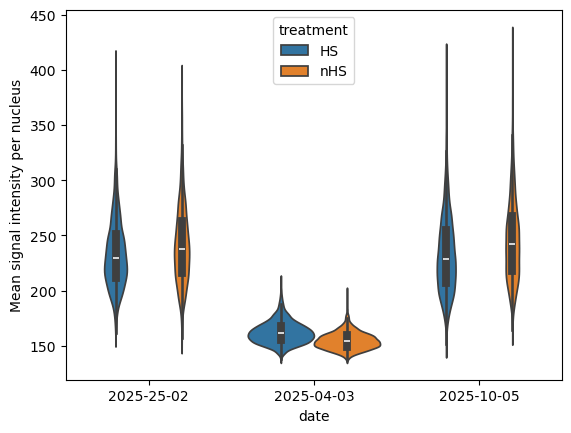

In [ ]:
# sns.violinplot(data=df,x='date',y='mean',hue='treatment')
# plt.ylabel("Mean signal intensity per nucleus")

Text(0, 0.5, 'Median signal intensity per nucleus')

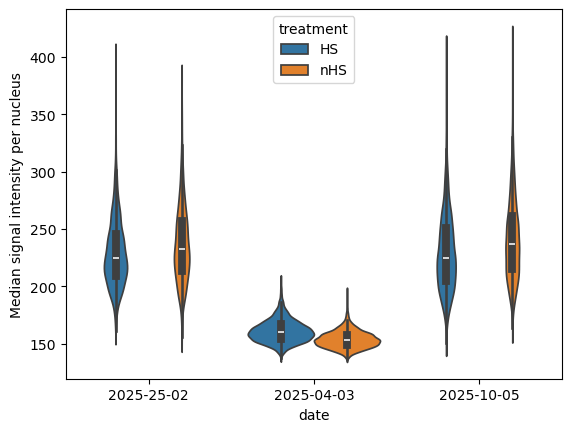

In [ ]:
# sns.violinplot(data=df,x='date',y='median',hue='treatment')
# plt.ylabel("Median signal intensity per nucleus")

In [402]:
# file_list['exposure_time'] = np.nan
# for index in range(0,len(file_list)):
#     img = BioImage(file_list.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
#     ome = img.ome_metadata
#     ome.structured_annotations[0].value
#     dd=ome.structured_annotations[0].value['ImageTextInfoLV']
#     d=json.loads(dd)
#     file_list.exposure_time.iloc[index] = re.sub('Exposure: ','',d['SLxImageTextInfo']['TextInfoItem_6'].split('\r\n')[1])


# file_list['exposure_time']

## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [459]:
def coefficientOfVariation(std,mean):
    return std/mean

df['cv'] = coefficientOfVariation(df['std'],df['mean'])

df.rename(columns={'worm_region_x':'worm_regions_all','worm_region_y':'worm_region'},inplace=True)
dist.rename(columns={'worm_region_x':'worm_regions_all','worm_region_y':'worm_region'},inplace=True)

df.head()


,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,worm_region,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,cv
0,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,4,0,1165,1516,18,1226,1592,50829.0,8.269571,1195.145960,1554.834543,79.421804,0.944163,head,18,61,76,298.028409,285.0,72.125074,15148486,5202.026303,776,142,50829,191.297495,26.368038,6239933,32619,0,3.0,0.065,4.500624,0.101562,0.005086,126.682630,1.601256,0.115015,0.023541,126.306016,0.242007
1,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,7,0,1242,1453,11,1287,1493,13317.0,4.737478,1263.519862,1472.512202,46.930152,0.956544,head,11,45,40,269.780281,262.0,53.416394,3592664,2853.311189,539,158,13317,198.251273,18.632973,1285263,6483,0,3.0,0.065,3.467476,0.123307,0.010198,33.257161,1.286456,0.060496,0.008451,1827.224019,0.198000
2,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,8,0,1255,1344,10,1315,1413,25591.0,4.039780,1284.752296,1376.016021,75.378188,0.952968,head,10,60,69,292.213395,291.0,41.006938,7478033,1681.568975,492,166,25591,240.168069,54.321522,3796817,15809,0,3.0,0.065,3.295061,0.199104,0.019946,27.641735,3.165281,0.283288,0.029160,24.052688,0.140332
3,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,9,0,1262,1491,12,1299,1537,13661.0,5.514896,1280.125540,1513.195300,49.023365,0.952185,head,12,37,46,286.522509,275.0,64.006227,3914184,4096.797037,532,150,13661,196.065060,27.467705,1325988,6763,0,3.0,0.065,4.179687,0.161282,0.009151,80.737633,1.300267,0.045974,0.006825,1441.559584,0.223390
4,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,head,10,0,1300,1375,24,1341,1438,21555.0,11.602320,1318.360334,1405.695523,71.424592,0.766264,head,24,41,63,312.091301,306.0,58.280308,6727128,3396.594308,623,184,21555,222.318520,65.913671,8989894,40437,0,3.0,0.065,3.704961,0.147764,0.011765,45.792264,4.749148,0.328757,0.015921,193.191211,0.186741


## Number of nuclei per worm/worm_region

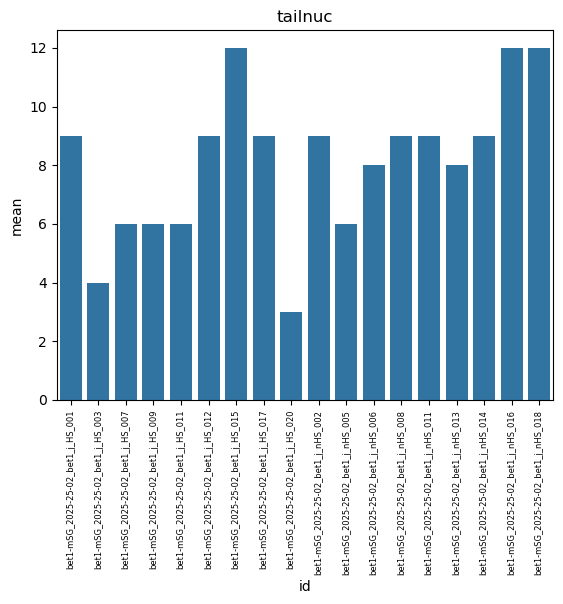

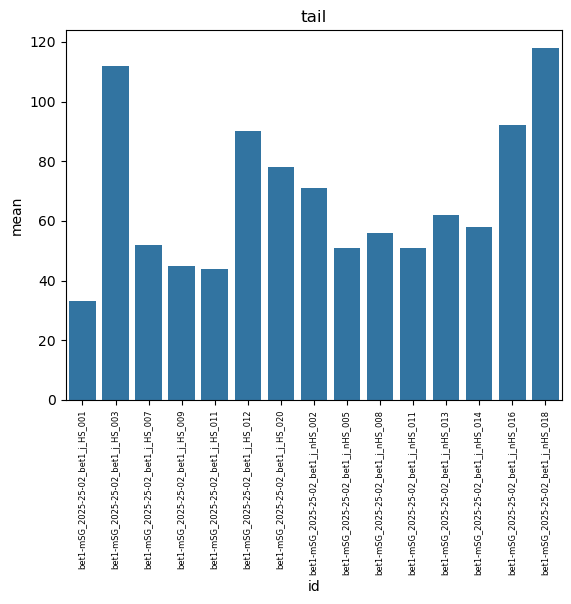

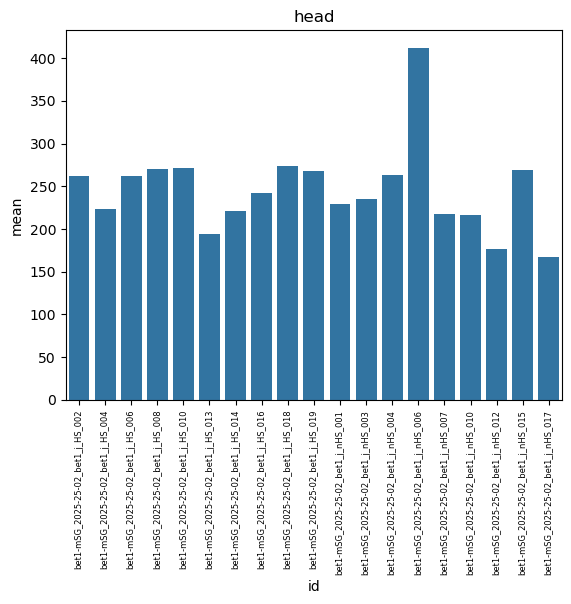

In [404]:
df_subset = df[(df['worm_region'] == "tailnuc")]
nucCounts=df_subset[df_subset.worm_region=="tailnuc"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("tailnuc")
plt.show()

df_subset = df[(df['worm_region'] == "tail")]
nucCounts=df_subset[df_subset.worm_region=="tail"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("tail")
plt.show()

df_subset = df[(df['worm_region'] == "head")]
nucCounts=df_subset[df_subset.worm_region=="head"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("head")
plt.show()


indeces_to_exclude = [18]

## Functions for plotting table metrics

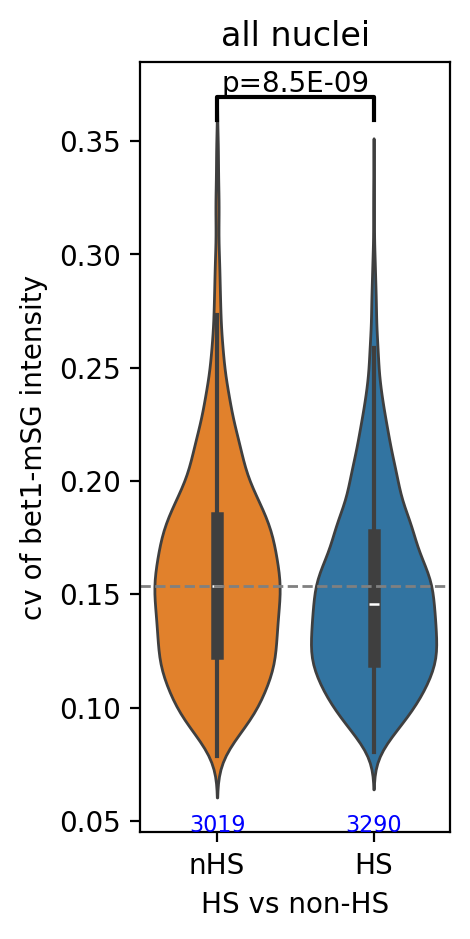

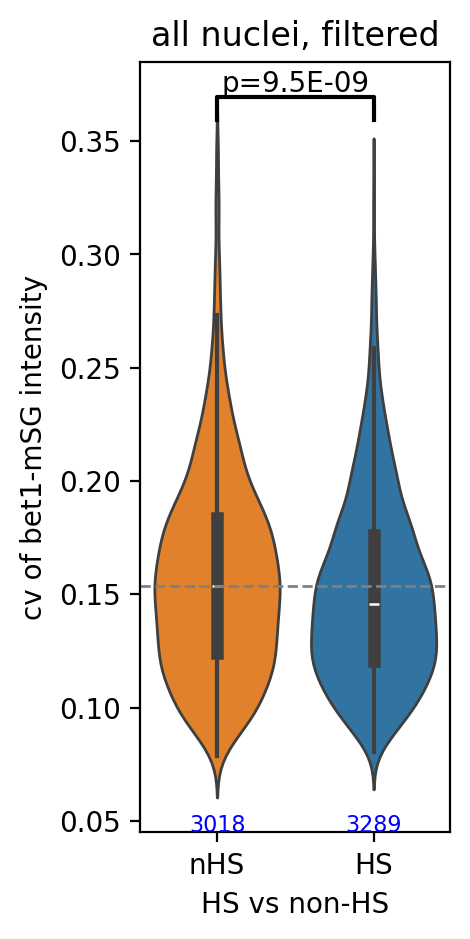

In [452]:
def format_p_value(pvalue):
    if pvalue < 0.001:
        return "{:.1E}".format(pvalue)
    else:
        return f"{pvalue:.3f}"


def plot_violin(df,file_list,output_path, metric='cv',title=''):
    p = df.protein.unique()[0]
    plt.figure(figsize = (2,5),dpi = 200)
    order= ['nHS', 'HS']
    ax=sns.violinplot(data=df, y=metric, x="treatment",hue="treatment", order=order, linewidth=1)
    
    res = mannwhitneyu(x=df[metric][df['treatment'] == "HS"], y=df[metric][df['treatment'] == "nHS"])
    # statistical annotation
    x1, x2 = 0, 1   
    y, h, col = df[metric].max() + 0.01, 0.01, 'k'

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "p="+format_p_value(res.pvalue), ha='center', va='bottom', color=col)

    plt.xlabel("HS vs non-HS")
    plt.ylabel(metric+" of "+p+" intensity")
    plt.title(title)

    # add horizontal line for t=0
    nHS_median = df[df['treatment'] == "nHS"][metric].median()
    plt.axhline(y=nHS_median, color='grey', linestyle='--', linewidth=1)

   # get number of nuclei at each timepoint
    num_nuclei = df.groupby(['treatment'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]+0.01*np.abs(ylims[0])
    for n in range(len(num_nuclei)):
        plt.text(x=num_nuclei.treatment.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')

    #plt.savefig(os.path.join(output_path,"plot_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))
    plt.show()

df_subset = df[(df['worm_region'] != 'tailnuc')]
plot_violin(df_subset,file_list,output_path, metric='cv',title='all nuclei')


df_subset = df[(df['solidity'] != np.inf) & (df['worm_region'] != 'tailnuc')]
plot_violin(df_subset,file_list,output_path, metric='cv',title='all nuclei, filtered')

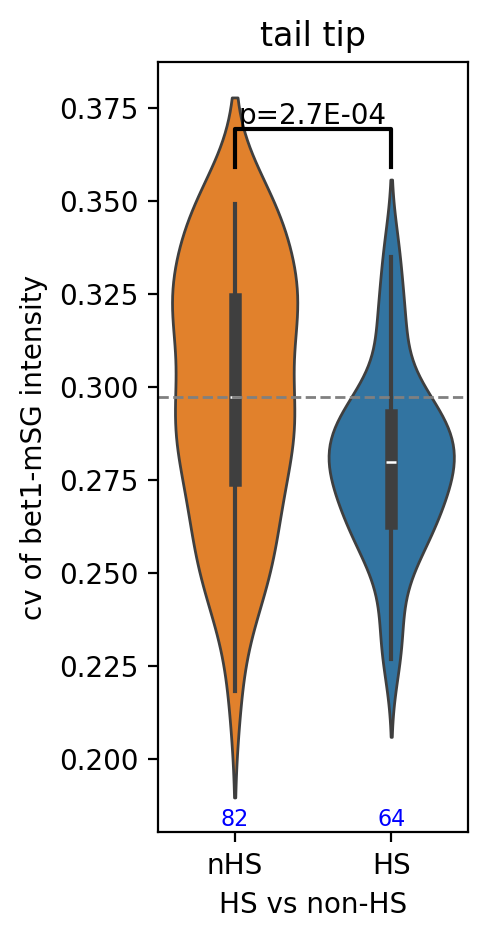

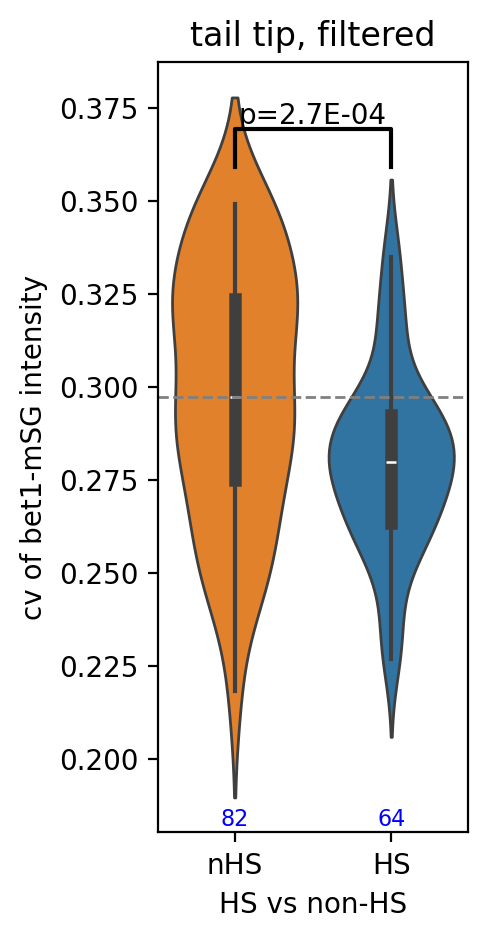

In [ ]:
df_subset = df[(df['worm_region'] == "tailnuc")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail tip')

df_subset = df[(df['worm_region'] == "tailnuc") & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv',title='tail tip, filtered')

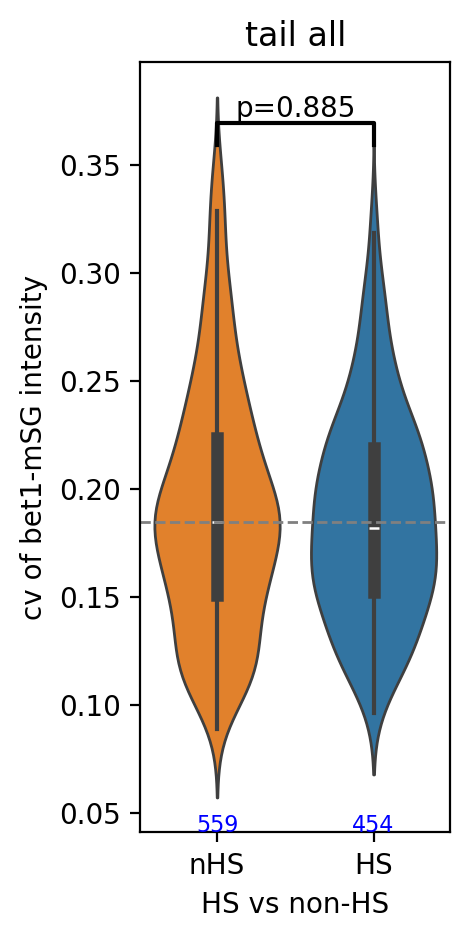

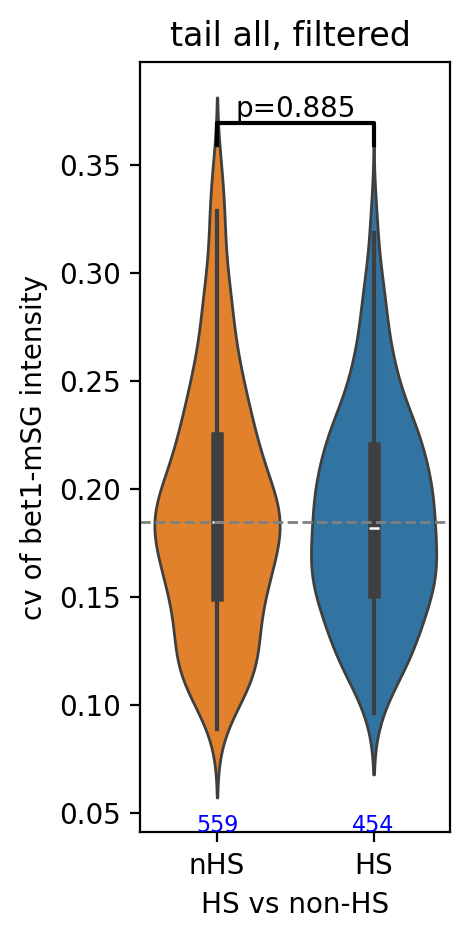

In [ ]:
df_subset = df[(df['worm_region'] == "tail")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail all')

df_subset = df[(df['worm_region'] == "tail") & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail all, filtered ')

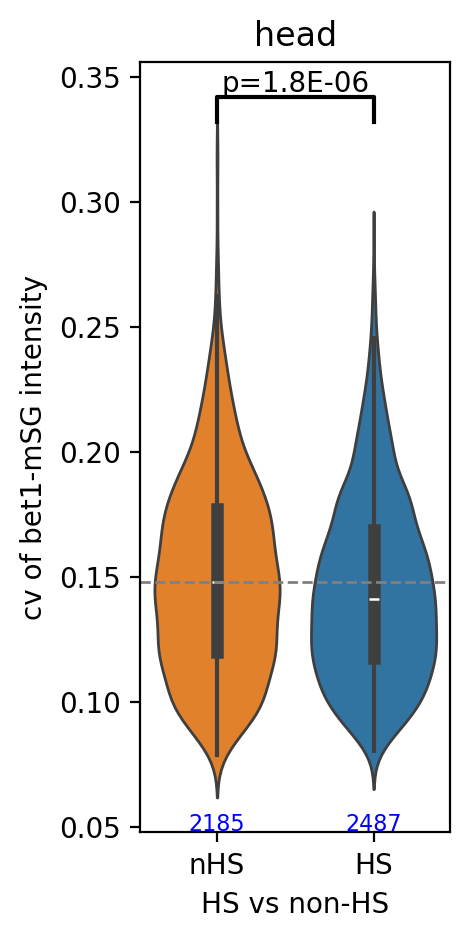

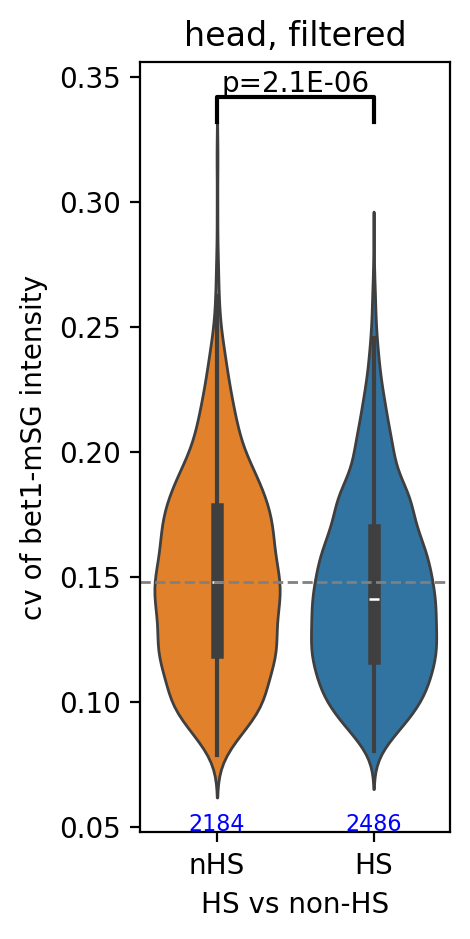

In [ ]:
df_subset = df[(df['worm_region'] == "head")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='head') 

df_subset = df[(df['worm_region'] == "head") & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='head')

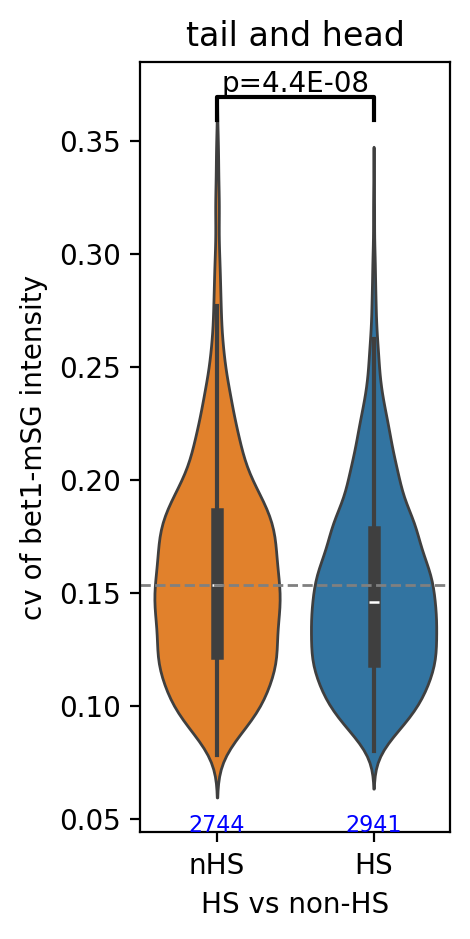

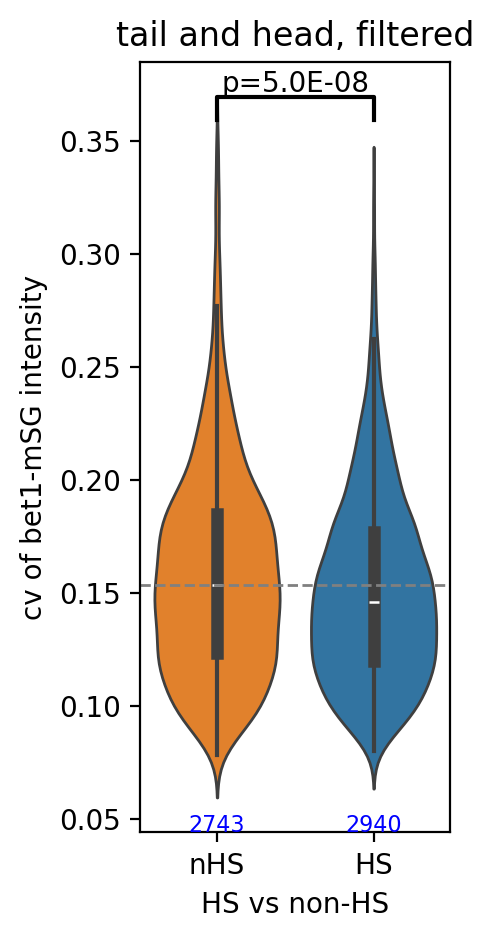

In [409]:
df_subset = df[(df['worm_region'] == "tail") | (df['worm_region'] == "head")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head')

df_subset = df[((df['worm_region'] == "tail") | (df['worm_region'] == "head")) & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head, filtered')

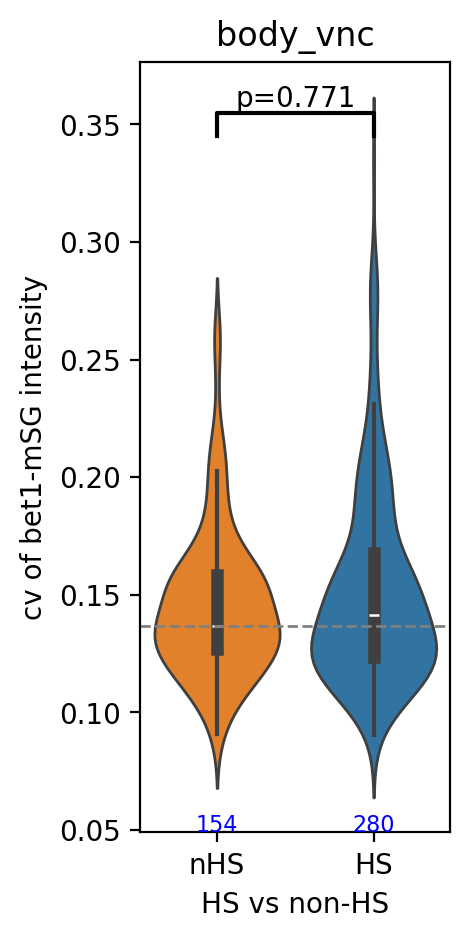

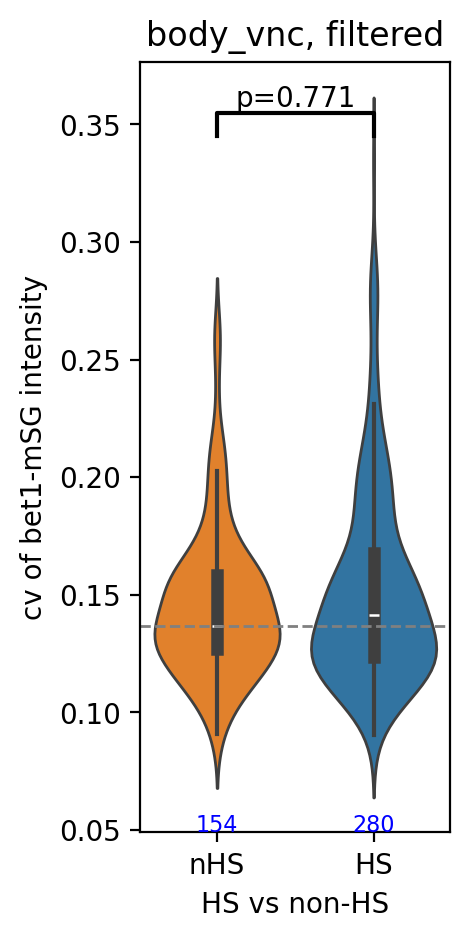

In [410]:
if(df['worm_region'].unique() == "body_vnc").any():

    df_subset = df[(df['worm_region'] == "body_vnc")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_vnc')

    df_subset = df[(df['worm_region'] == "body_vnc") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_vnc, filtered')

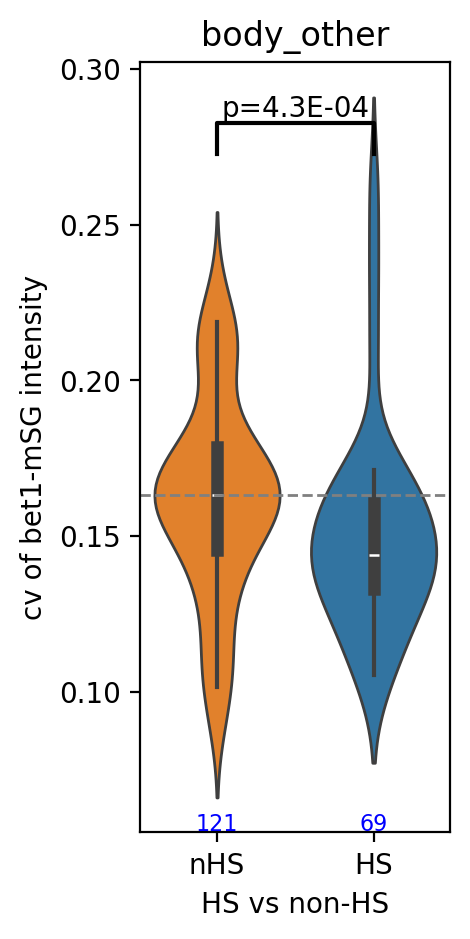

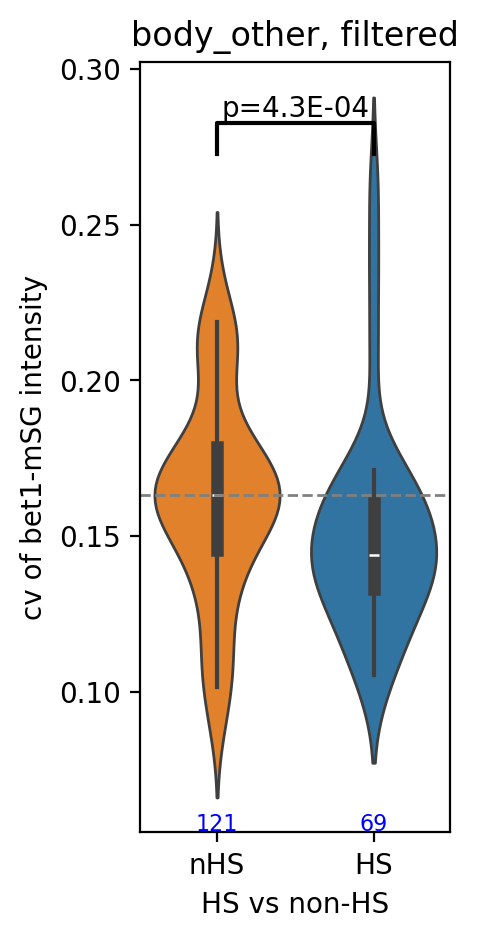

In [411]:
if(df['worm_region'].unique() == "body_other").any():

    df_subset = df[(df['worm_region'] == "body_other")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_other')

    df_subset = df[(df['worm_region'] == "body_other") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_other, filtered')

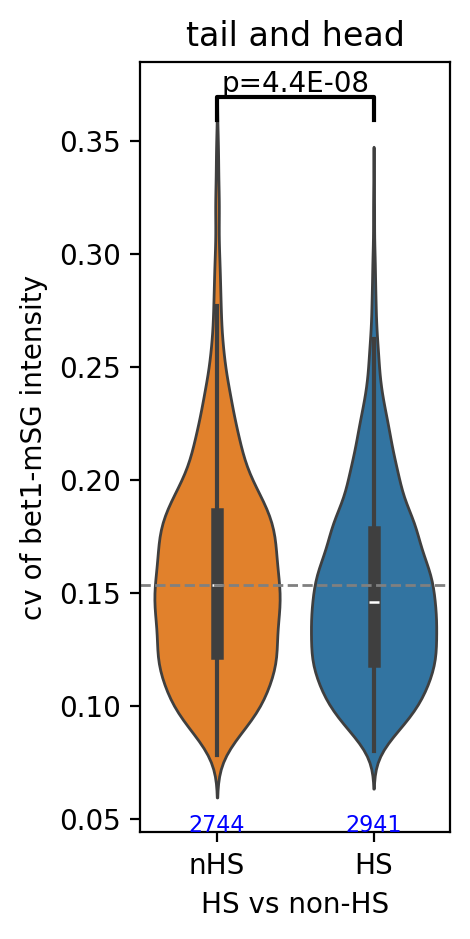

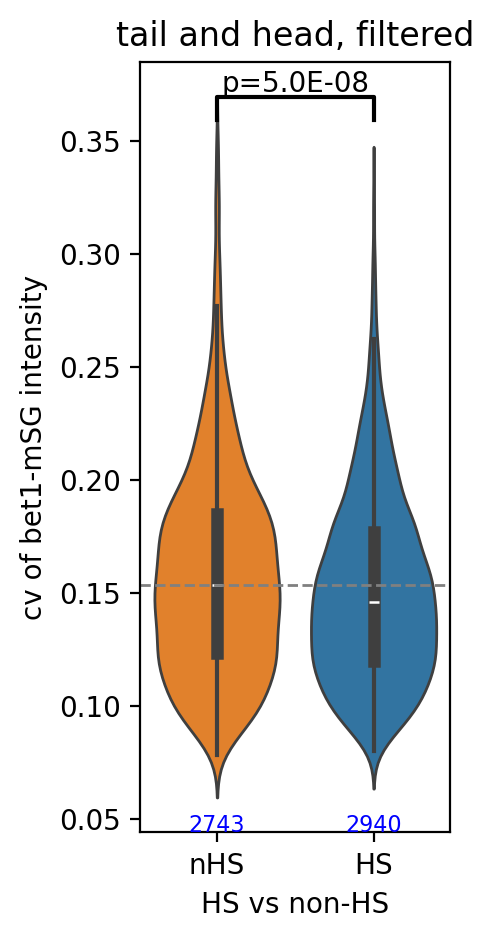

In [412]:
df_subset = df[(df['worm_region'] == "tail") | (df['worm_region'] == "head")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head')

df_subset = df[((df['worm_region'] == "tail") | (df['worm_region'] == "head")) & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head, filtered')

## Look at individual worms to see how consistant result is


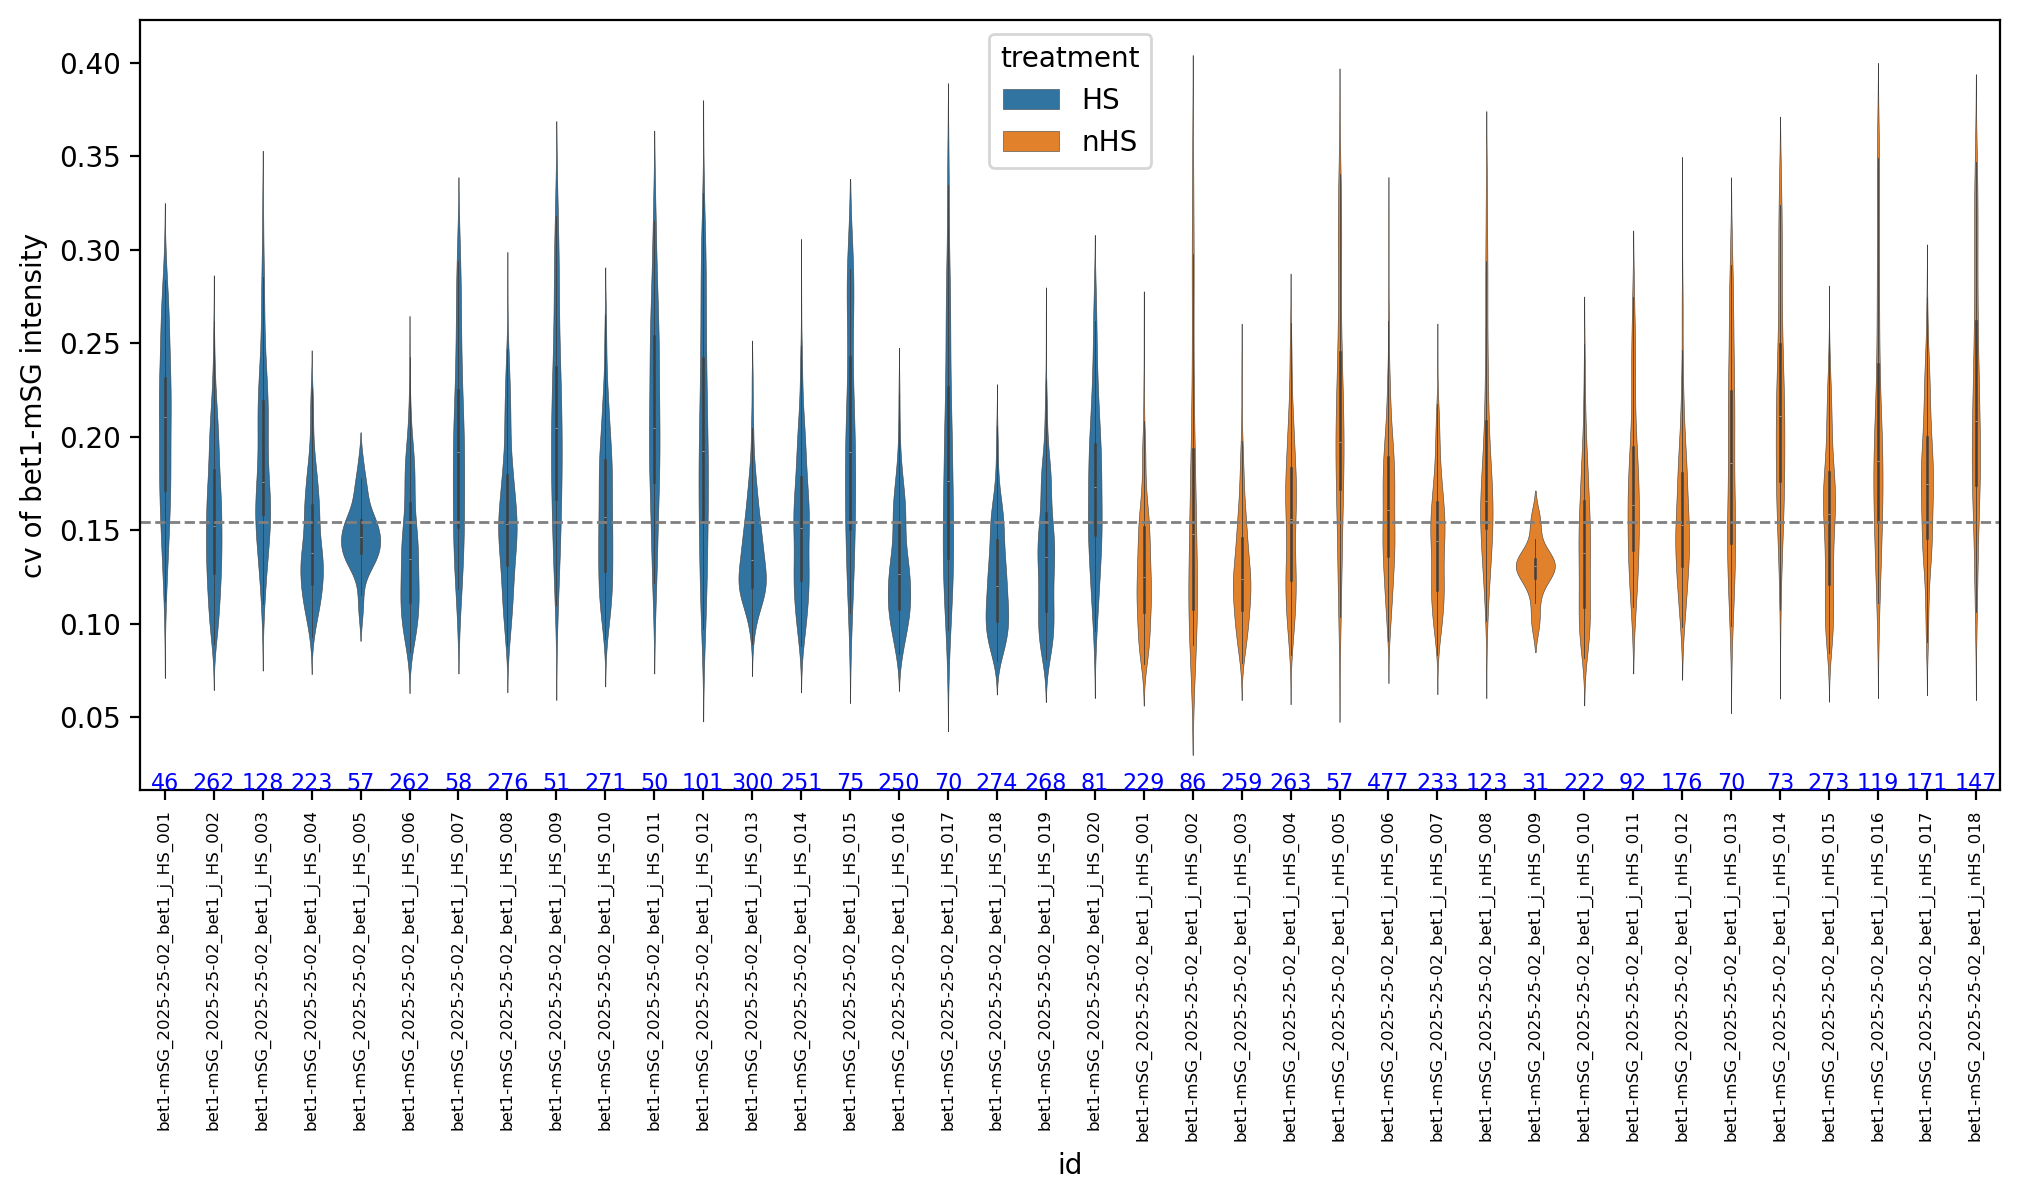

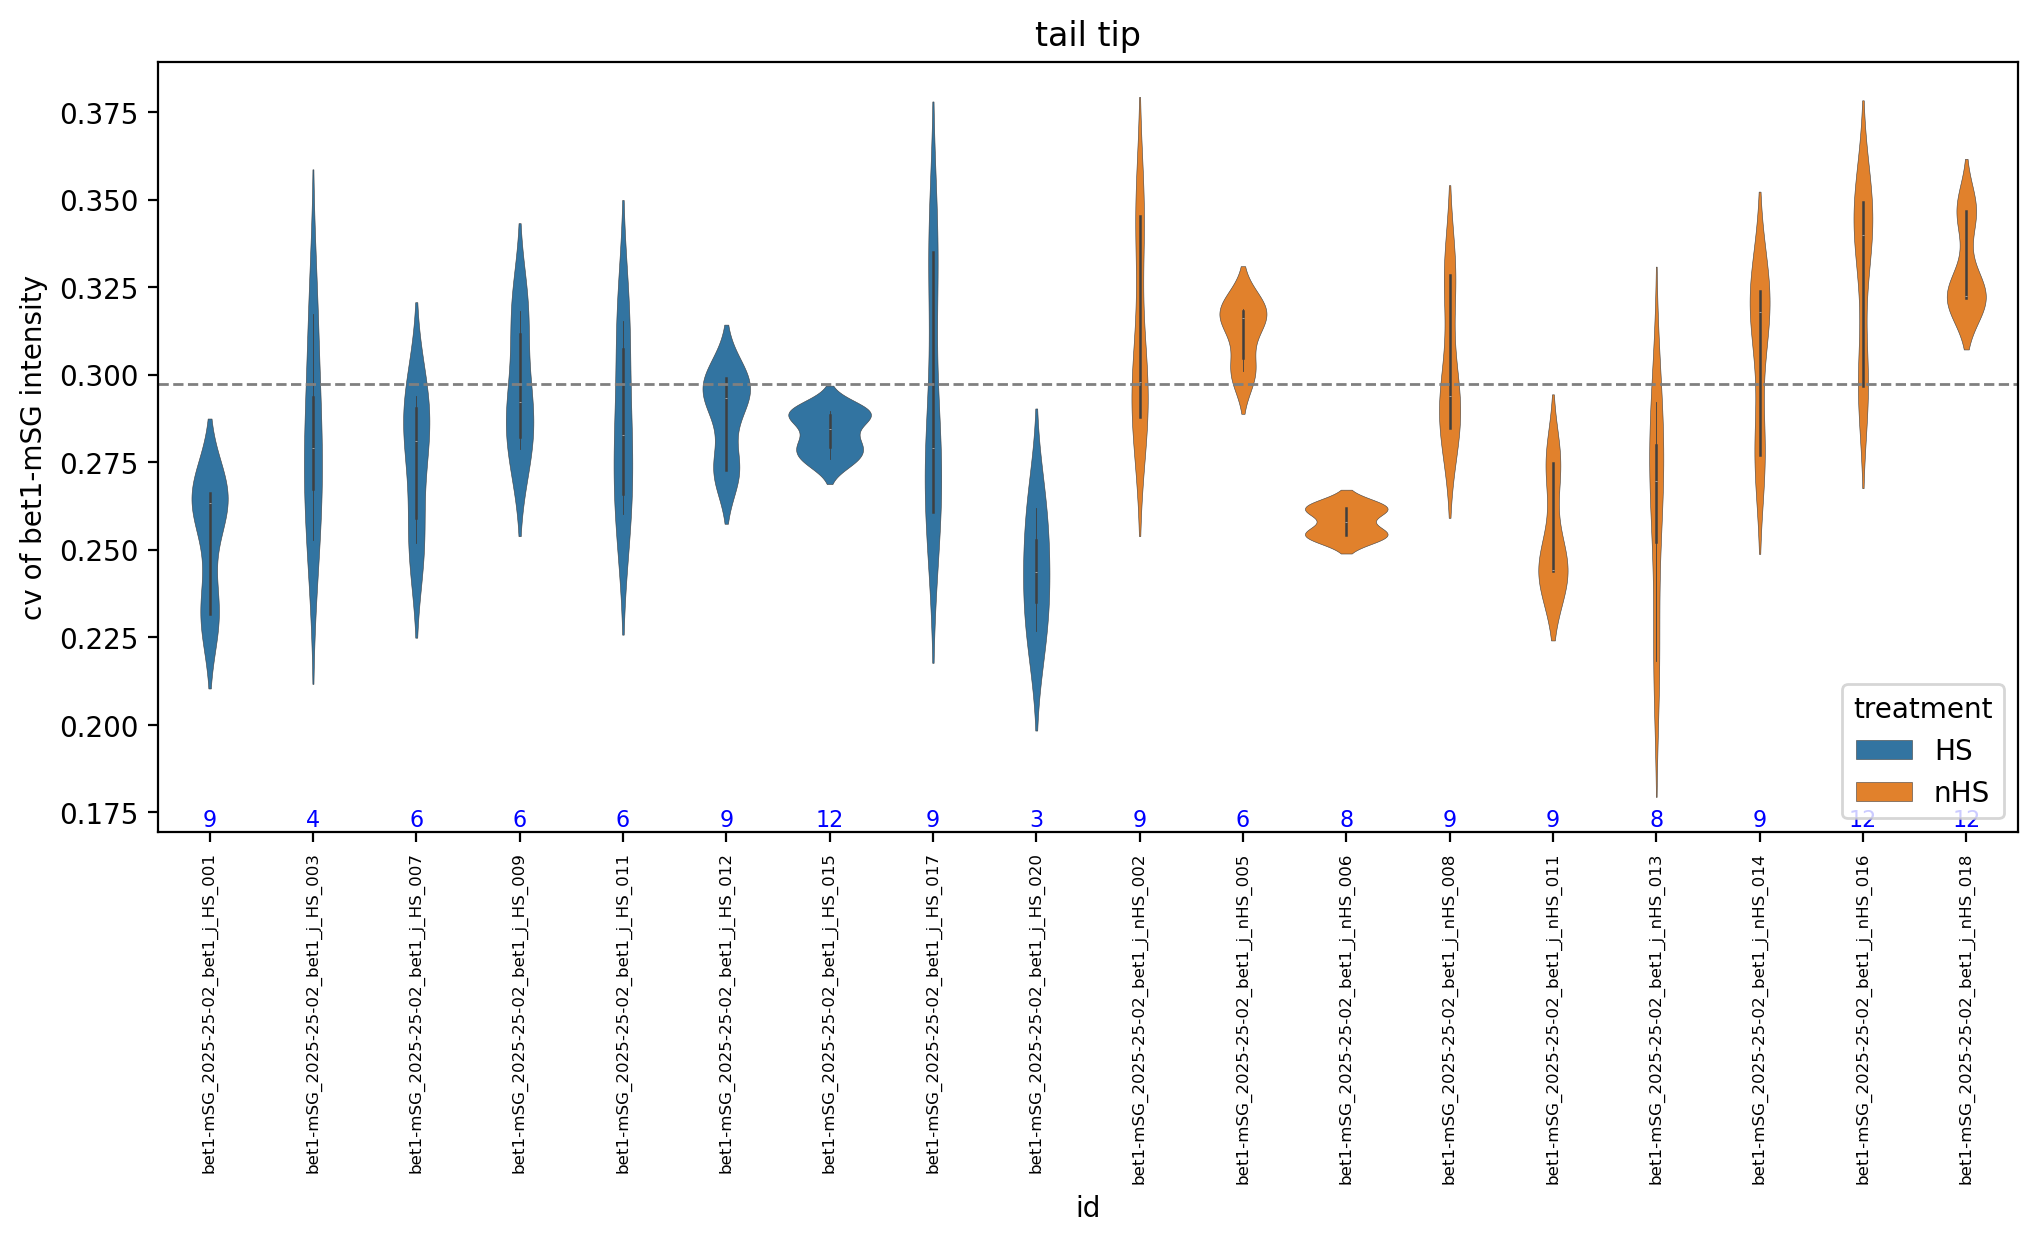

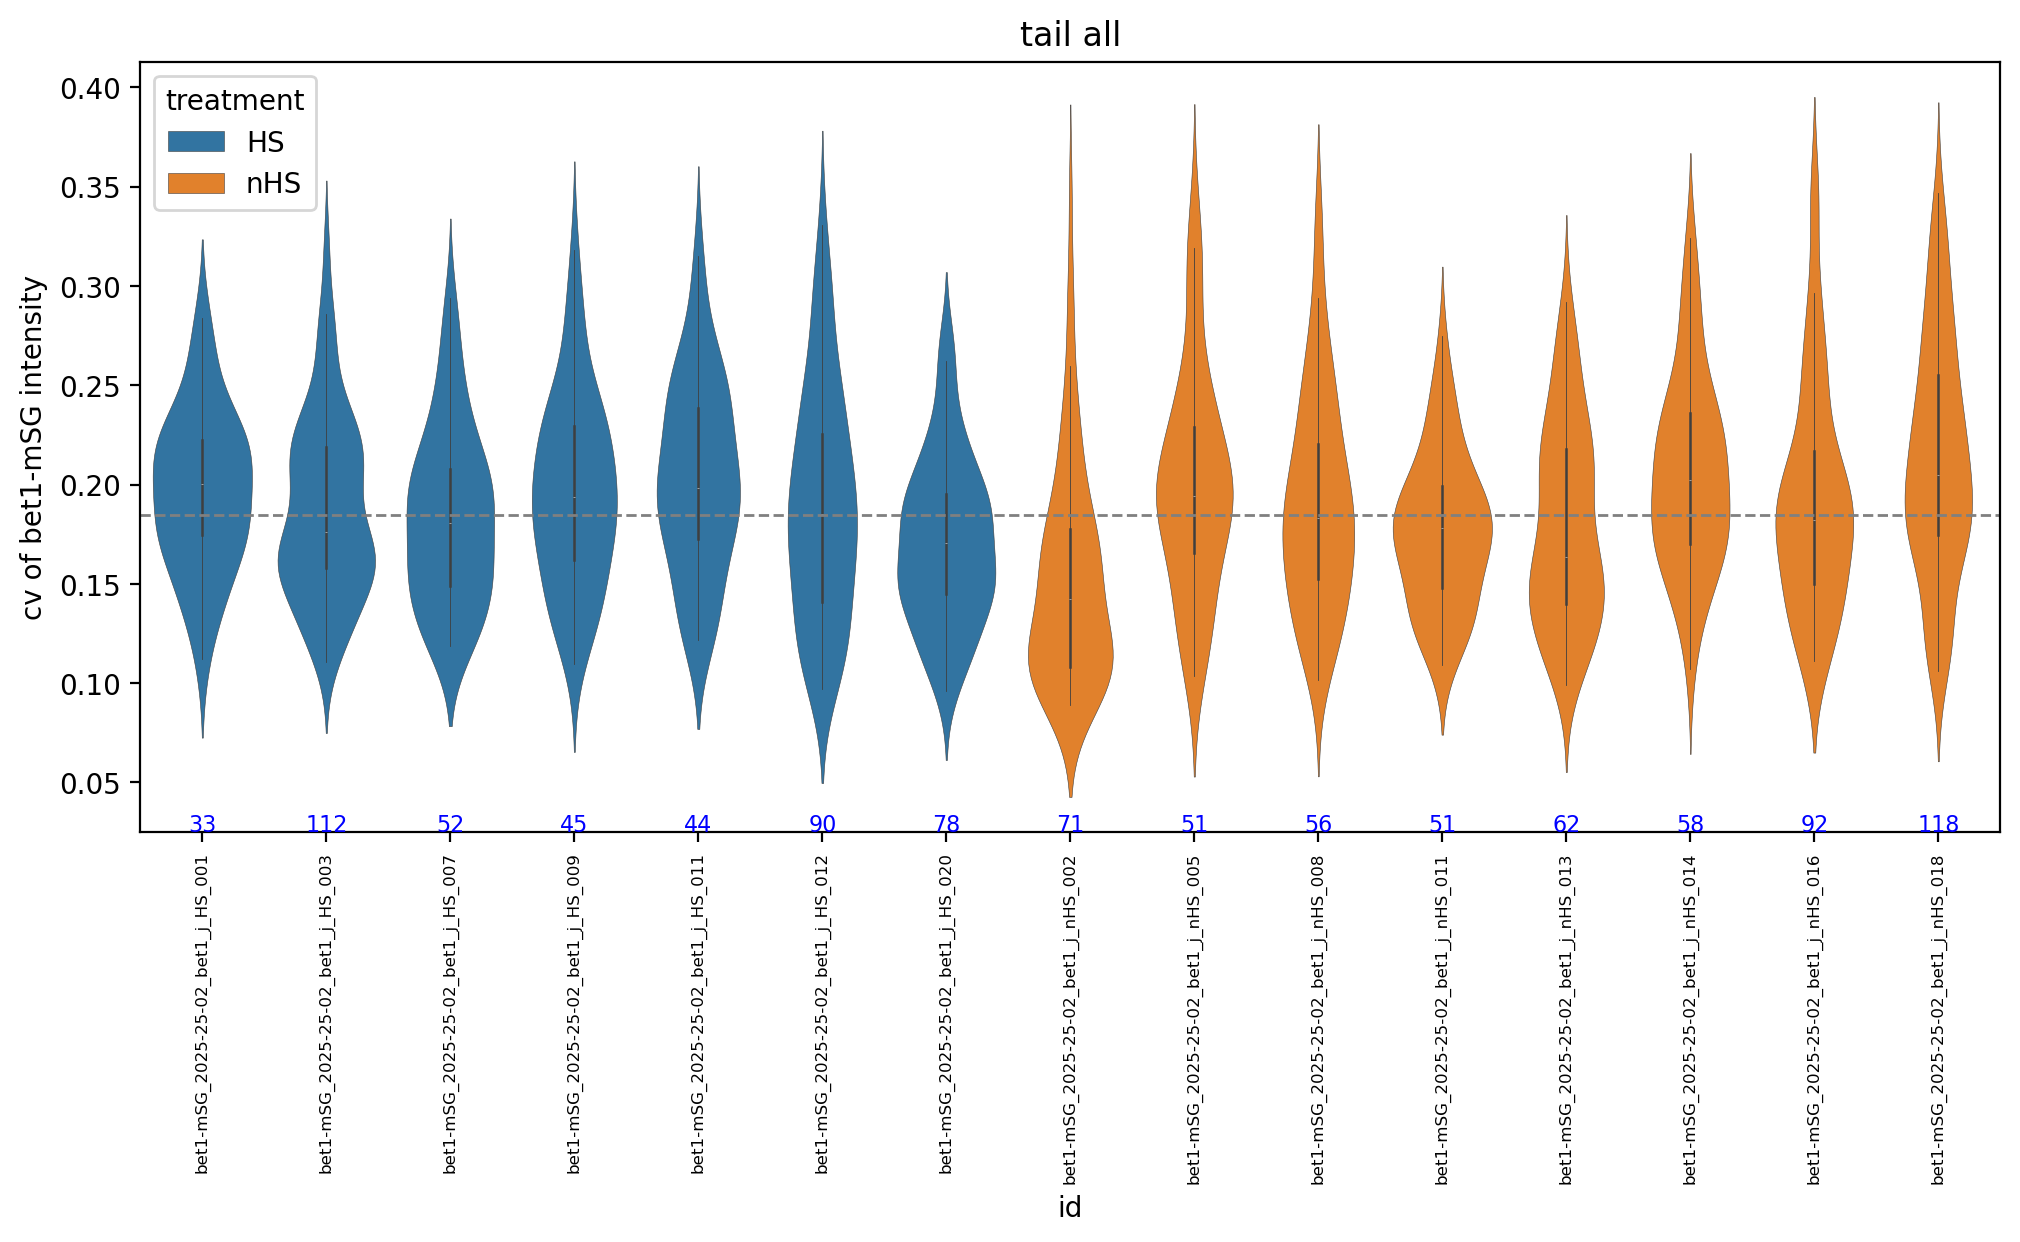

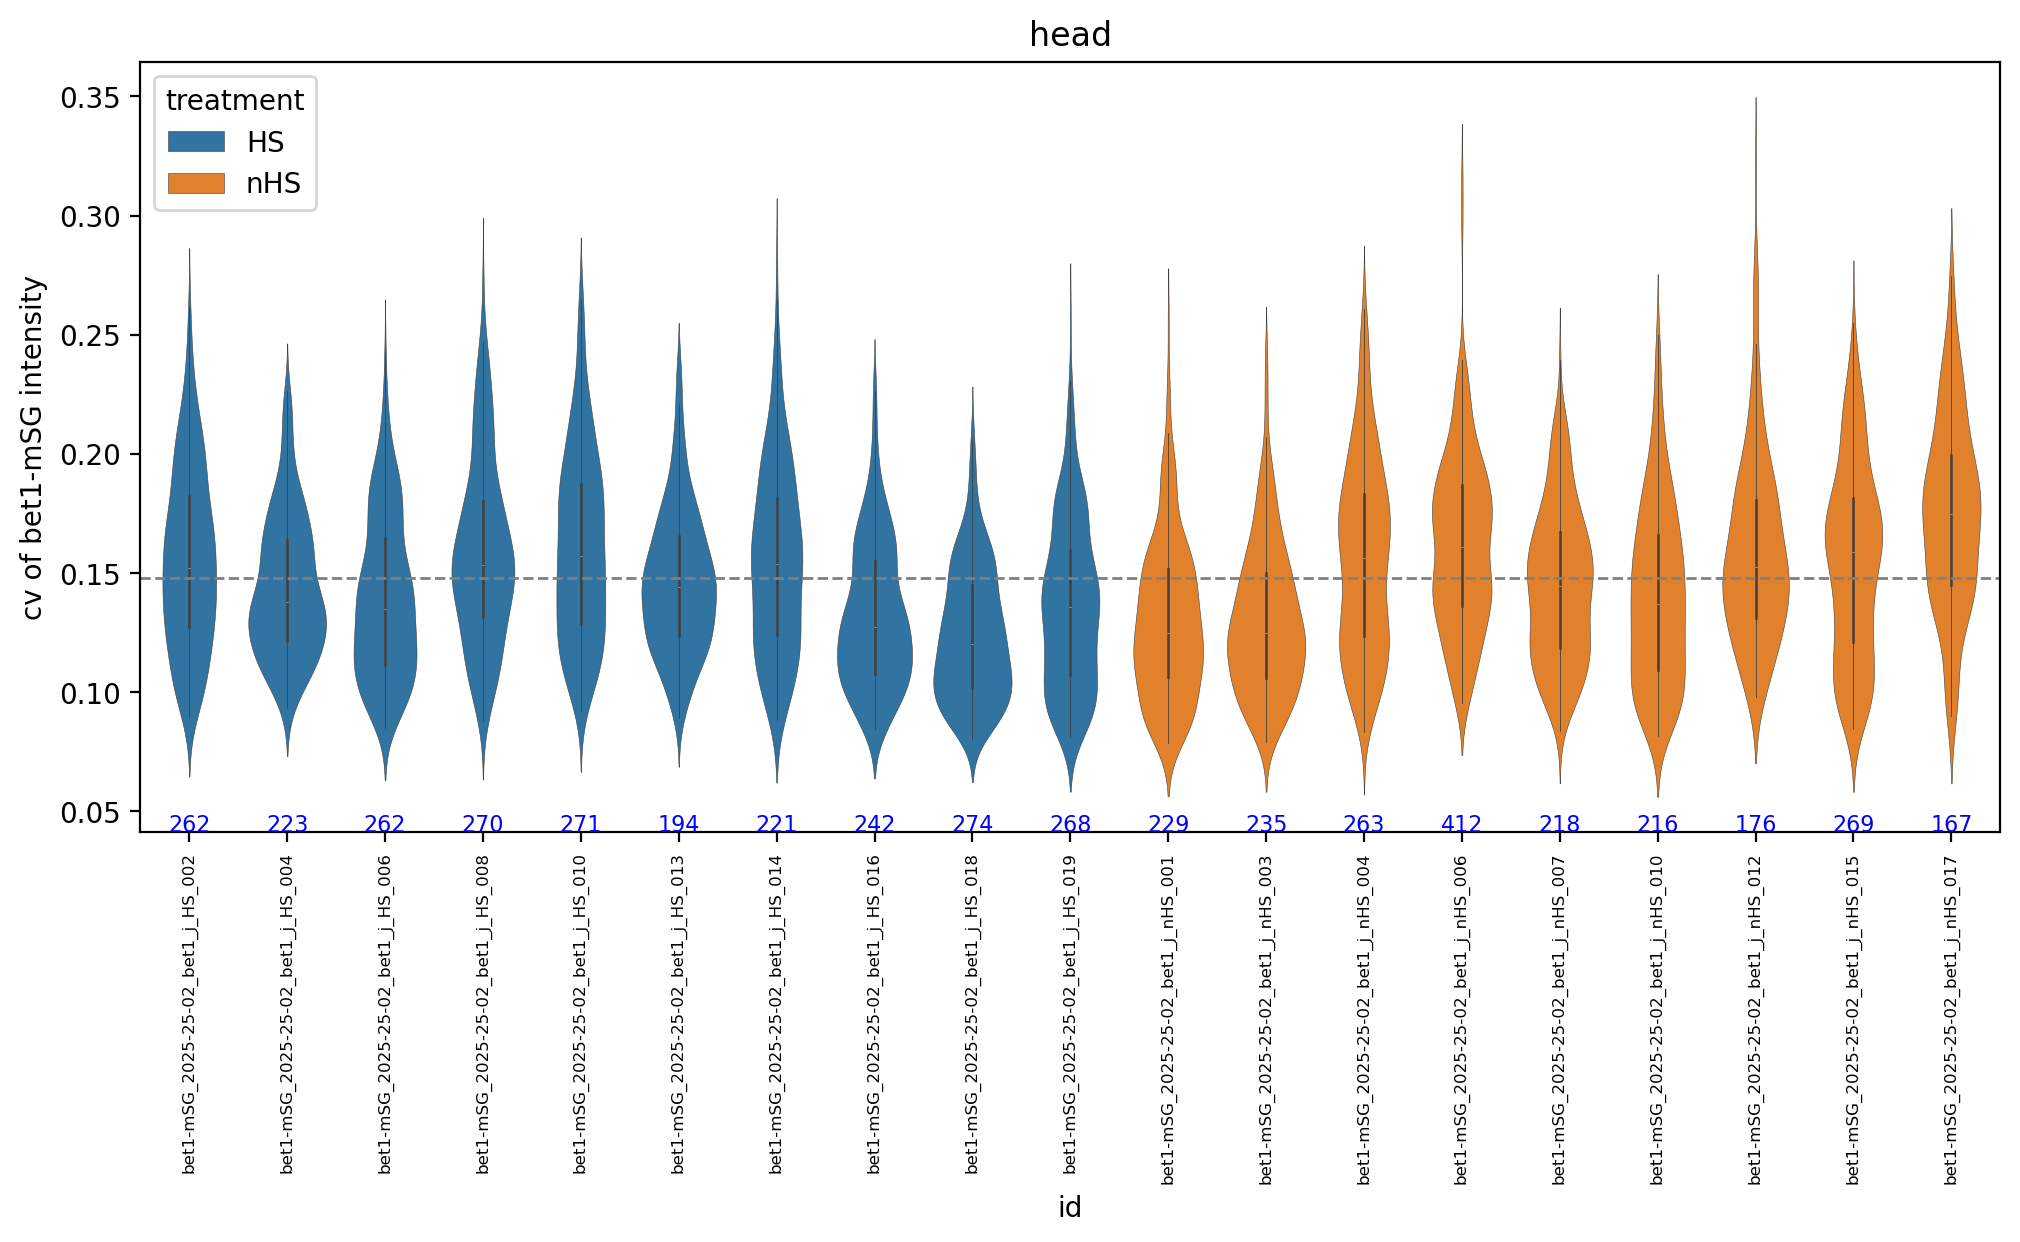

In [413]:
def plot_violin_by_worm(df,file_list,output_path, metric='cv',title=''):
    p = df.protein.unique()[0]
    plt.figure(figsize = (12,5),dpi = 200)
    order= ['nHS', 'HS']
    sns.violinplot(data=df, y=metric, x="id",hue='treatment',linewidth=0.2)

    plt.ylabel(metric+" of "+p+" intensity")
    plt.xticks(rotation=90,size=6)

    # add horizontal line for t=0
    nHS_median = df[df['treatment'] == "nHS"][metric].median()
    plt.axhline(y=nHS_median, color='grey', linestyle='--', linewidth=1)

   # get number of nuclei at each timepoint
    num_nuclei = df.groupby(['id'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]+0.01*np.abs(ylims[0])
    for n in range(len(num_nuclei)):
        plt.text(x=num_nuclei.id.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')

    plt.title(title)
    #plt.savefig(os.path.join(output_path,"plot_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))
    plt.show()


plot_violin_by_worm(df,file_list,output_path, metric='cv')

df_subset = df[(df['worm_region'] == "tailnuc")]
plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='tail tip')

df_subset = df[(df['worm_region'] == "tail")]
plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='tail all')

df_subset = df[(df['worm_region'] == "head")]
plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='head')

## Functions for diagnostic plots to look at individual nuclei interactively

In [414]:
def showSegmentation(df, index):
    if nucChannel != spotChannel:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Image '+str(index)+' of '+ str(len(df)))
    im0 = axs[0].imshow(df.zproj_spots.iloc[index], cmap='gray')
    axs[0].text(0, 0, np.round(df.spot_ac_length.iloc[index],2), color='white', fontsize=12,va='top')
    plt.colorbar(im0, ax=axs[0],orientation='horizontal')

    im1 = axs[1].imshow(df.zproj_background.iloc[index], cmap='gray')
    axs[1].text(0, 0, np.round(df.bg_ac_length.iloc[index],2), color='black', fontsize=12,va='top')
    plt.colorbar(im1, ax=axs[1],orientation='horizontal')
    
    if nucChannel != spotChannel:
        im2 = axs[2].imshow(df.zproj_nuclei.iloc[index], cmap='gray')
        axs[2].text(0, 0, np.round(df.nuc_ac_length.iloc[index],2), color='white', fontsize=12,va='top')
        plt.colorbar(im2, ax=axs[1],orientation='horizontal')
    
    axs[0].set_title(df.id.iloc[index]+' t'+str(df.timepoint.iloc[index])+' lab'+str(df.label.iloc[index]))

    plt.show()
    

def selectImages(df, maxImages=10):
    chosenSet = pd.DataFrame()
    for i in range(len(df)):
        if chosenSet.shape[0] < maxImages:
            clear_output(wait=True)
            showSegmentation(df, i)
            response = input("Press Enter to continue...")
            if response=='s':
                chosenSet = pd.concat([chosenSet, df.iloc[i:(i+1)]], ignore_index=True)
                continue
            if response=='q':
                break
            else:
                continue
    return chosenSet



def showImages(df):
    for i in range(len(df)):
            clear_output(wait=True)
            showSegmentation(df, i)
            response = input("Press Enter to continue...")
            if response=='q':
                break
            else:
                continue

def exponential_decay(x, a, b,c):
    '''
    Exponenetial decay function for autocorrelation
    according to Munschi et al. 2025.
    '''                           
    return a + b * np.exp(-c * x)


def plot_acf_from_table(df, i,image_type="spot"):
    '''
    Plots the autocorrelation function for a specific row in the DataFrame
    and displays the corresponding image in a second subplot.
    '''
    img = df['zproj_spots'].iloc[i]
    #zdim=img.shape[0]
    img_mask = df['image'].iloc[i]
    autocorr = df[image_type+'_ACF'].iloc[i] #get_autocorrelation_2d(img, img_mask, maxr=12)
    fit = df[image_type+'_ac_fittedParams'].iloc[i]
    conditionNumber = df[image_type+'_ac_conditionNumber'].iloc[i]
    rmse = df[image_type+'_ac_rmse'].iloc[i]
    ac_length = df[image_type+'_ac_length'].iloc[i]
    ac_error = df[image_type+'_ac_error'].iloc[i]
    x = range(1, autocorr.size + 1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # Plot the autocorrelation function in the first subplot
    axes[0].plot(x, autocorr, 'o', label='data')
    try:
        axes[0].plot(x, exponential_decay(x, *fit), label='fit')
    except:
        pass
    axes[0].legend()
    axes[0].set_title('Autocorrelation nucleus #'+str(i))
    axes[0].set_xlabel('Distance')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].text(0.5, 0.5, 
                 f'lambda = {ac_length:.3f} +/- {ac_error:.3f}', 
                 transform=axes[0].transAxes)
    axes[0].text(0.5, 0.6, f'fit: a={fit[0]:.3g},\nb={fit[1]:.3g},\nc={fit[2]:.3g}', 
                 transform=axes[0].transAxes)
    axes[0].text(0.5, 0.7, 'RMSE = {:.3g}'.format(rmse), transform=axes[0].transAxes)
    axes[0].text(0.5, 0.8, 'conditionNumber = {:.3g}'.format(conditionNumber), transform=axes[0].transAxes)
    # Display the image in the second subplot
    axes[1].imshow(img, cmap='gray')
    axes[1].set_title(image_type+' Channel')
    axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

In [415]:
def plot_ac_length_histogram(dist,image_type="spot",title=""):
    percentile = dist.bg_ac_length.quantile(0.99)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    dist[image_type+'_ac_length'].hist(bins=100, ax=axs[0])
    axs[0].set_title(image_type+" all AC lengths")
    axs[0].axvline(percentile, color='red', linestyle='--', label=f'background 99th Percentile: {percentile:.2f}')
    axs[0].legend()
    axs[0].text(0.5, 0.8, f'{dist[image_type+"_ac_length"].isna().sum():.0f} NaNs out of {dist.shape[0]:.0f} total', 
                transform=axs[0].transAxes)
    axs[0].text(0.5, 0.9, f'{np.sum(dist[image_type+"_ac_length"]==0):.0f} 0s out of {dist.shape[0]:.0f} total', 
                transform=axs[0].transAxes)
    dfss = dist[(np.abs(dist[image_type+'_ac_length']) < 12)]
    dfss[image_type+'_ac_length'].hist(bins=100,ax=axs[1])
    axs[1].set_title(image_type+" abs(AC lengths) < 12 "+title)
    axs[1].set_xlim(1,12)
    axs[1].axvline(percentile, color='red', linestyle='--', label=f'background 99th Percentile: {percentile:.2f}')
    axs[1].legend()
    plt.show()

## Functions for calculating autocorrelation per worm

In [416]:
def exponential_decay(x, a, b,c):
    '''
    Exponenetial decay function for autocorrelation
    according to Munschi et al. 2025.
    '''                           
    return a + b * np.exp(-c * x) 


def fit_acf_sd(acf_mean, acf_std, num_nuclei = 1):
    '''
    Fits parameters of an exponential decay function 
    to the autocorrelation values, taking into
    account the standard deviation of the values.
    Used for multiple nuclei from single image.
    '''
    x=range(0,acf_mean.size)
    initialguess = [0.2, 0.8, 0.5]
    if(num_nuclei > 1):
        try:
            fit, covariance = optimize.curve_fit(           
                exponential_decay,                                     
                x,   
                acf_mean,     
                initialguess,
                sigma=acf_std,
                absolute_sigma=False,
                bounds=([0., 0., 0.], [1., 1., 100.]))
            rmse = np.sqrt(np.mean((acf_mean - exponential_decay(x, *fit))**2))
            conditionNumber = np.linalg.cond(covariance)  
        except RuntimeError:
            fit = [0,0,0] #[np.nan, np.nan, np.nan]
            covariance = np.zeros((3,3))
            rmse = np.nan
            conditionNumber = np.nan
    else:
        try:
            fit, covariance = optimize.curve_fit(           
                exponential_decay,                                     
                x,   
                acf_mean,    
                initialguess,
                bounds=([0., 0., 0.], [1., 1., 100.]))
            rmse = np.sqrt(np.mean((acf_mean - exponential_decay(x, *fit))**2))
            conditionNumber = np.linalg.cond(covariance) 
        except RuntimeError:
            fit = [0,0,0]#[np.nan, np.nan, np.nan]
            covariance = np.zeros((3,3))
            rmse = np.nan
            conditionNumber = np.nan
    return(fit, covariance, acf_mean, acf_std, rmse, conditionNumber)


def correlation_length(fit):
    '''
    Calculates correlation length according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        x0=1
        lam=x0+np.log(2)/c
    else: 
        lam = 0 #np.nan
    return(lam)


def correlation_error(fit,cov):
    '''
    Calculates correlation length error according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        sigma_c = np.sqrt(cov[2,2])
        lam = correlation_length(fit)
        lam_error = lam*sigma_c/c
    else:
        lam_error = 0 #np.nan
    return(lam_error)


def get_mean_autocorrelation_length(acf_matrix):
    '''
    Calculates autocorrelation length from matrix of ACF 
    (each row is a single nucleus ACF)
    '''
    acf_mean = acf_matrix[~np.isnan(acf_matrix[:,0]) & (acf_matrix[:,0]>0) ].mean(axis=0)
    acf_std = acf_matrix[~np.isnan(acf_matrix[:,0]) & (acf_matrix[:,0]>0) ].std(axis=0)
    num_nuclei = acf_matrix.shape[0]
    fit, cov, acf_mean, acf_std, rmse, conditionNumber = fit_acf_sd(acf_mean,acf_std,num_nuclei)
    if np.nan not in fit:
        lam = correlation_length(fit)
        lam_error = correlation_error(fit, cov)
        if(np.abs(lam)<np.abs(lam_error)):
            lam = 0#np.nan
            lam_error = 0#np.nan
    else:
        lam = 0#np.nan
        lam_error = 0#np.nan
    return(acf_mean, acf_std, lam, lam_error, fit, conditionNumber)


def plot_qc_embryo_acf(acf_matrix, id, tp, image_type="spots"):
    '''
    Plots the ACF of a single embryo.
    acf_matrix: ACF matrix of the embryo
    id: embryo ID
    tp: timepoint
    '''
    acf_mean, acf_std, lam, lam_error, spots_fit, conditionNumber = get_mean_autocorrelation_length(acf_matrix)
    n, m = acf_matrix.shape  # Get the dimensions of the array

    # Create x-coordinates (1 to 12) repeated for each row
    xx = np.tile(np.arange(1, m + 1), n)

    # Create y-coordinates (values from the array)
    yy = acf_matrix.flatten()

    # Plot the points
    plt.figure(figsize=(10, 6))
    plt.scatter(xx, yy, alpha=0.7, s=8, c='blue', label='ACF per nucleus')
    plt.title("Mean ACF of "+image_type+" per embryo "+id+" t"+str(tp))
    plt.xlabel("distance")
    plt.ylabel("autocorrelation")

    # Generate x values for the distance (1 to the length of the mean ACF)
    x = np.arange(1, len(acf_mean) + 1)

    # Calculate the fitted curve using the fit parameters
    fitted_curve = exponential_decay(x, *spots_fit)

    # Plot the mean autocorrelation function with the fitted curve
    plt.plot(x, acf_mean, 'x', label='Mean ACF', color='red')
    plt.plot(x, fitted_curve, '-', label='Fitted Curve', color='red')

    # Add a ribbon for the standard deviation
    plt.fill_between(x, acf_mean - acf_std, acf_mean + acf_std, 
                    color='red', alpha=0.2, label='Standard Deviation')
    plt.legend()

    plt.text(0.5, 0.8, f' lambda = {lam:.3f} +/- {lam_error:.3f}, {acf_matrix.shape[0]} nuclei', 
                transform=axs[0].transAxes)

    plt.show()

In [417]:
def get_mean_autocorrelation_for_plotting(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['id','treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        id = grouped_acf.index.get_level_values(0)[i]
        tr = grouped_acf.index.get_level_values(1)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(id, tr)]
        ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.000001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['id'] = [id]
            df_tmp['treatment'] = tr
            df_tmp[image_type+'_mean_ac_length'] = lam
            df_tmp[image_type+'_mean_ac_error'] = lam_error
            df_tmp[image_type+'_num_nuclei'] = ac.shape[0]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting





def plot_acf_per_worm(ac_for_plotting, image_type="spot",title=""):
    ac_for_plotting = ac_for_plotting.dropna()
    plt.figure(figsize=(10, 6))
    #plt.ylim(0, 10)
    scatter = sns.scatterplot(data=ac_for_plotting, x='id', y=image_type+'_mean_ac_length', hue='treatment',
                            palette='tab10', alpha=0.8)    
    plt.xticks(rotation=90, size=6)
    # Get the colors assigned to each 'id' from the scatter plot
    palette = scatter.legend_.legend_handles
    id_to_color = {label.get_text(): handle.get_color() for label, handle in zip(scatter.legend_.texts, palette)}


    for _, row in ac_for_plotting.iterrows():
        plt.errorbar(
            x=row['id'],
            y=row[image_type+'_mean_ac_length'],
            yerr=row[image_type+'_mean_ac_error'],
            fmt='o',
            color=id_to_color[row['treatment']],
            alpha=0.8,
            capsize=3)

    # get number of nuclei at each timepoint
    # num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]#+0.1*np.abs(ylims[0])
    id_to_index = {id_value: index for index, id_value in enumerate(ac_for_plotting['id'].unique())}

    for n, row in ac_for_plotting.iterrows():
        plt.text(x=row.id, y=ypos*1.01, s=row[image_type+'_num_nuclei'],  fontsize=8, ha='center',color=id_to_color[row['treatment']],rotation=90)   

    plt.title(title)
    



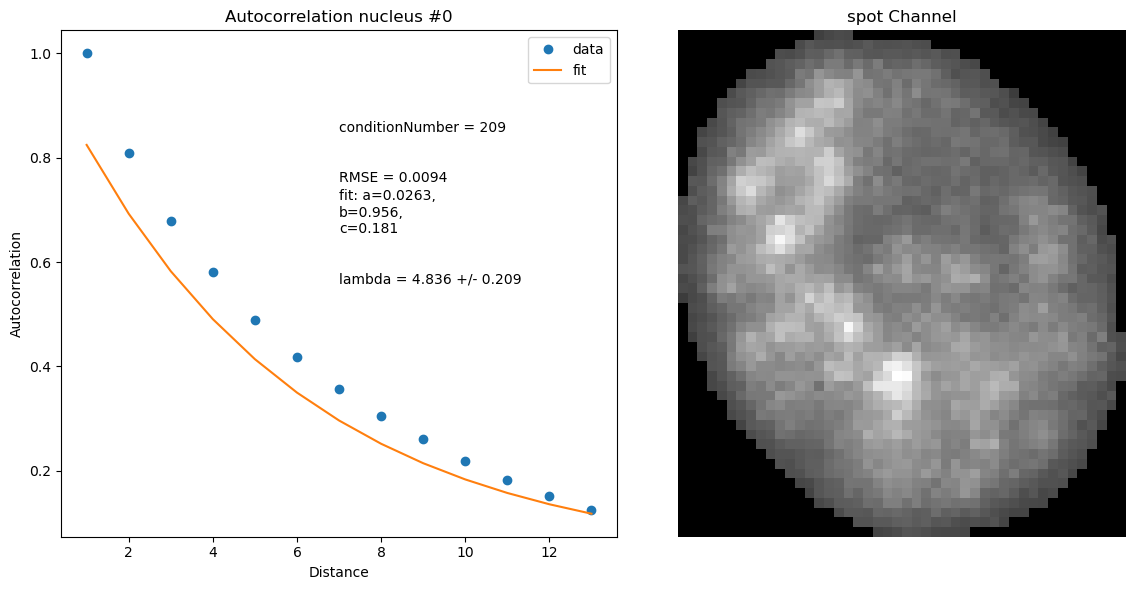

In [418]:
plot_acf_from_table(dist, 0,image_type="spot")

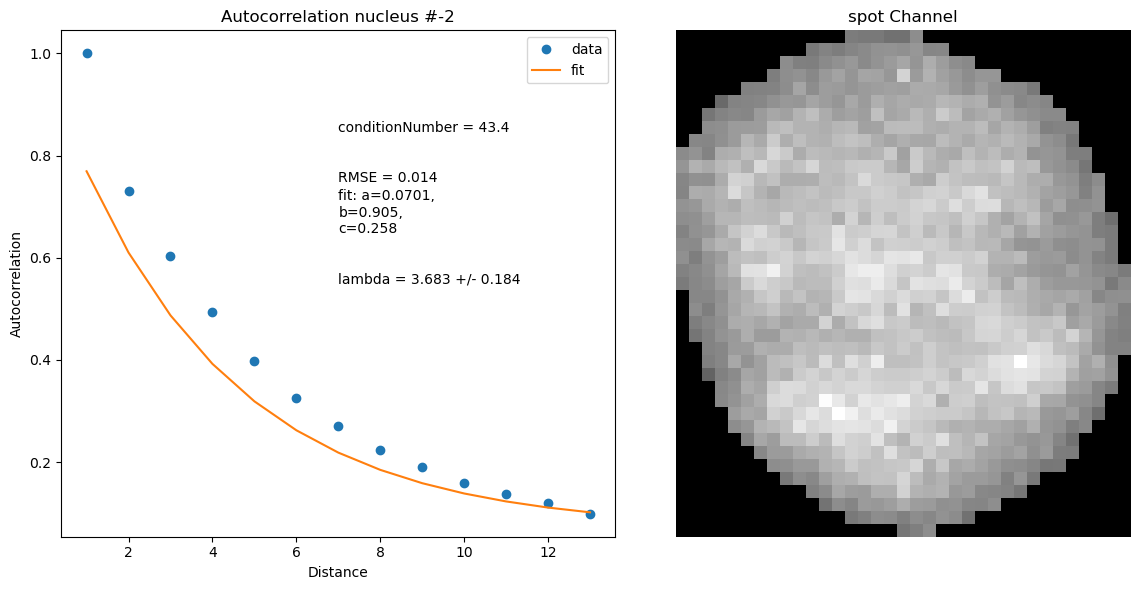

In [419]:
plot_acf_from_table(dist, -2,image_type="spot")

## Functions for plotting autocorrelation per treatment

In [420]:
def get_mean_autocorrelation_for_plotting_1var(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        tr = grouped_acf.index.get_level_values(0)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(tr)]
        #ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.0001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['treatment'] = [tr]
            df_tmp[image_type+'_mean_ac_length'] = lam
            df_tmp[image_type+'_mean_ac_error'] = lam_error
            df_tmp[image_type+'_num_nuclei'] = ac.shape[0]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting


def plot_acf_per_treatment(ac_for_plotting, image_type="spot"):
    ac_for_plotting = ac_for_plotting.dropna()
    plt.figure(figsize=(2, 5))
    #plt.ylim(0, 10)
    scatter = sns.scatterplot(data=ac_for_plotting, x='treatment', y=image_type+'_mean_ac_length',     
                               hue='treatment', palette='tab10', alpha=0.8)    
    plt.xticks(rotation=90, size=6)
    # Get the colors assigned to each 'id' from the scatter plot
    palette = scatter.legend_.legend_handles
    id_to_color = {label.get_text(): handle.get_color() for label, handle in zip(scatter.legend_.texts, palette)}


    for _, row in ac_for_plotting.iterrows():
        plt.errorbar(
            x=row['treatment'],
            y=row[image_type+'_mean_ac_length'],
            yerr=row[image_type+'_mean_ac_error'],
            fmt='o',
            color=id_to_color[row['treatment']],
            alpha=0.8,
            capsize=3)

    # get number of nuclei at each timepoint
    # num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]#+0.1*np.abs(ylims[0])
    id_to_index = {id_value: index for index, id_value in enumerate(ac_for_plotting['treatment'].unique())}

    for n, row in ac_for_plotting.iterrows():
        plt.text(x=row.treatment, y=ypos*1.001, s=row[image_type+'_num_nuclei'],  fontsize=8, ha='center',color=id_to_color[row['treatment']],rotation=0)  

In [421]:
def get_acf_curves(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        tr = grouped_acf.index.get_level_values(0)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(tr)]
        ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.0001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['image_type'] = [image_type]
            df_tmp['treatment'] = [tr]
            df_tmp['mean_ac_length'] = lam
            df_tmp['mean_ac_error'] = lam_error
            df_tmp['num_nuclei'] = ac.shape[0]
            df_tmp['ACF'] = [acf_mean]
            df_tmp['ACF_std'] = [acf_std]
            df_tmp['ACF_fit'] = [fit]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting




In [422]:
def plot_ac_length_barplot(dist, title=""):
    spotCurves = get_acf_curves(dist,image_type="spot") 
    bgCurves = get_acf_curves(dist,image_type="bg") 

    curves = pd.concat([bgCurves, spotCurves], ignore_index=True)
    curves.reset_index(drop=True, inplace=True)
    curves['mean_ac_length_nm'] = curves['mean_ac_length']*dist.pixelSize.iloc[0]*1000
    curves['mean_ac_error_nm'] = curves['mean_ac_error']*dist.pixelSize.iloc[0]*1000

    curves=curves.sort_values(by=['treatment'],ascending=False).sort_values(by=['image_type'],ascending=True).reset_index(drop=True)

    fig,ax = plt.subplots(figsize=(5, 8))
    x=np.arange(2)
    bar_width=0.3
    b1 = ax.bar(x, curves.mean_ac_length_nm[curves.treatment=="nHS"], 
                yerr=curves.mean_ac_error_nm[curves.treatment=="nHS"], capsize=5,
            width=bar_width, label='nHS')

    b2 = ax.bar(x+bar_width, curves.mean_ac_length_nm[curves.treatment=="HS"], 
                yerr=curves.mean_ac_error_nm[curves.treatment=="HS"], capsize=5,
            width=bar_width, label='HS')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(['Background', 'emr-1::mSG'])
    ax.set_ylabel('Autocorrelation length (nm)')
    ax.legend()
    ax.set_title(title)



## plot autocorrelation


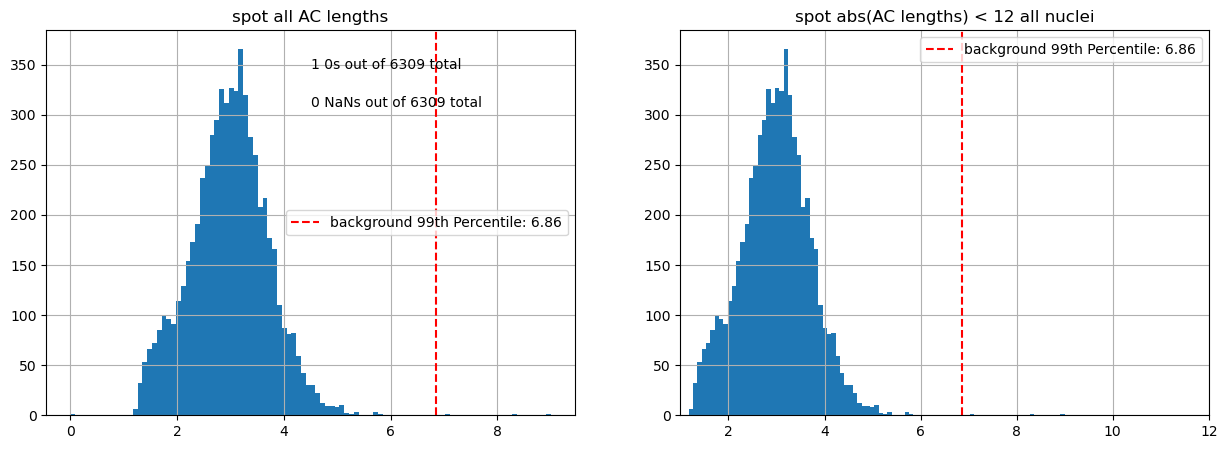

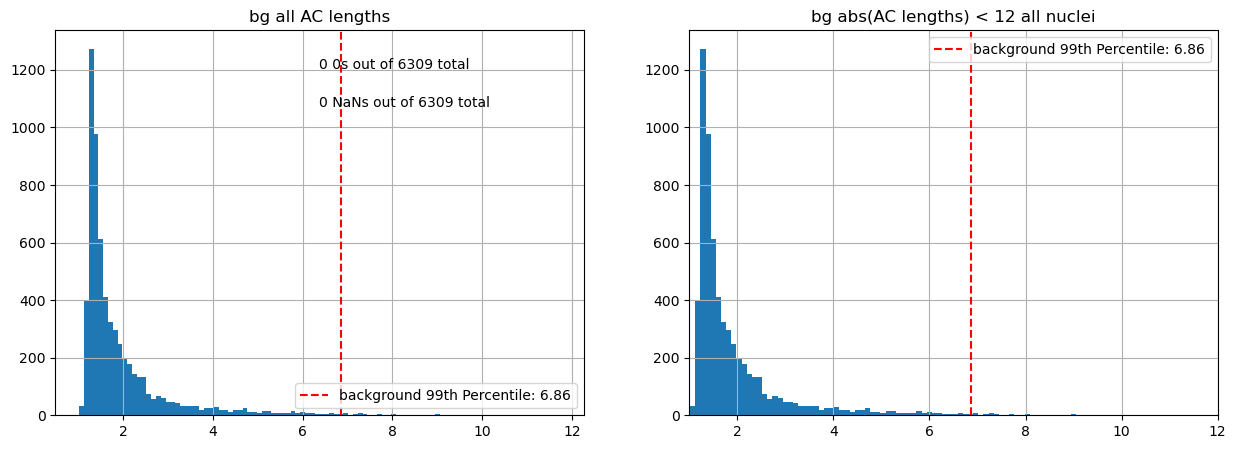

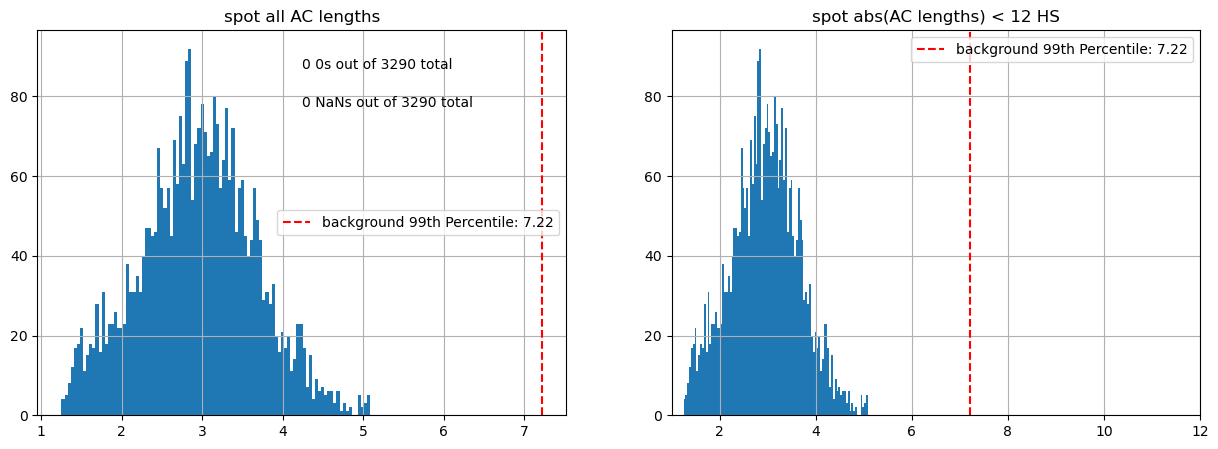

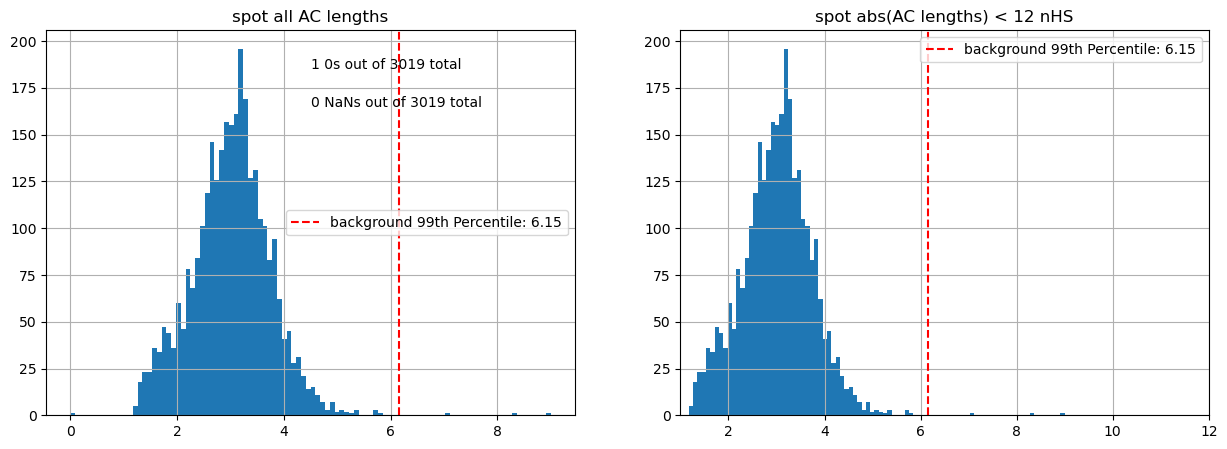

In [423]:

dist_subset=dist[(dist['worm_region'] != 'tailnuc')]

plot_ac_length_histogram(dist_subset, image_type="spot",title="all nuclei")

plot_ac_length_histogram(dist_subset, image_type="bg",title="all nuclei")


plot_ac_length_histogram(dist_subset[dist_subset.treatment=="HS"], image_type="spot", title="HS")

plot_ac_length_histogram(dist_subset[dist_subset.treatment=="nHS"], image_type="spot", title="nHS")


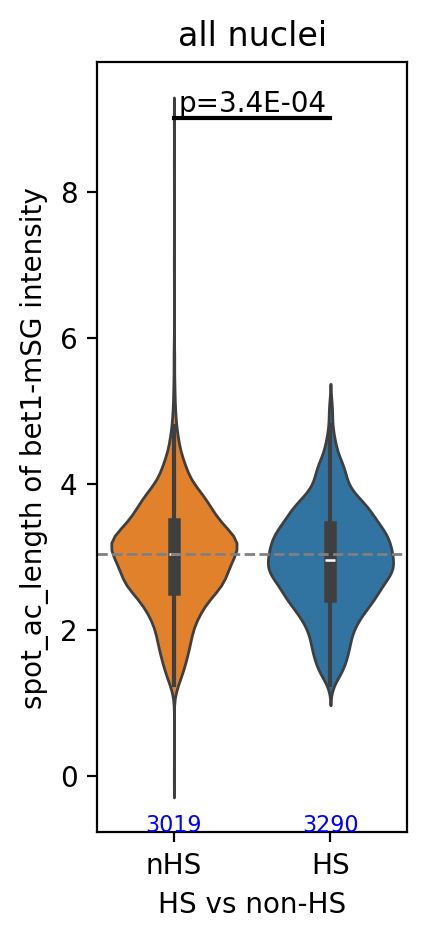

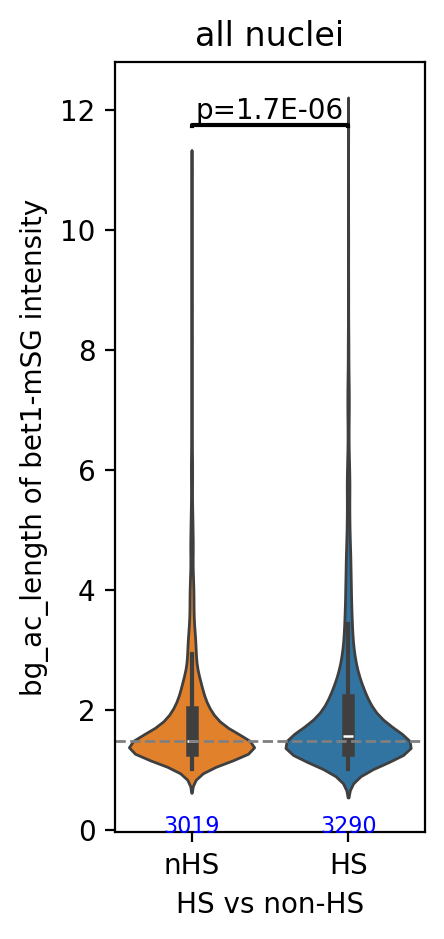

In [453]:
df_subset = df[(df['worm_region'] != "tailnuc")]
plot_violin(df_subset,file_list,output_path, metric='spot_ac_length', title='all nuclei')

plot_violin(df_subset,file_list,output_path, metric='bg_ac_length', title='all nuclei')

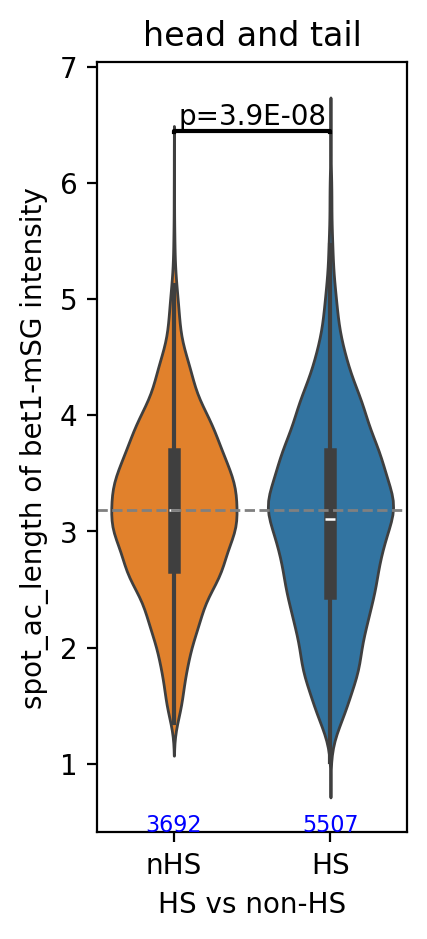

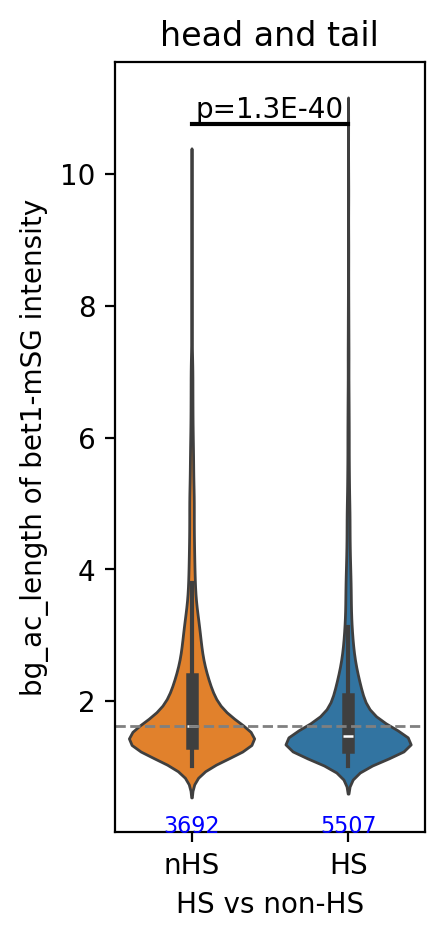

In [462]:
df_subset = df[(df['worm_region'] == "tail") | (df['worm_region'] == "head") ]
plot_violin(df_subset,file_list,output_path, metric='spot_ac_length', title='head and tail')

plot_violin(df_subset,file_list,output_path, metric='bg_ac_length', title='head and tail')

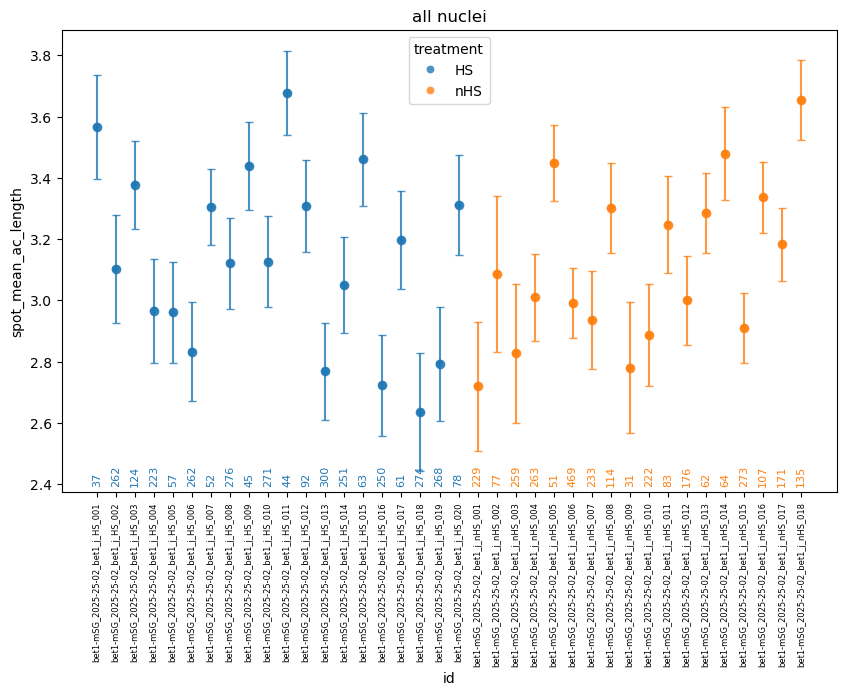

In [425]:
dist_subset = dist[(dist['worm_region'] != "tailnuc")]
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist_subset,image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='all nuclei')

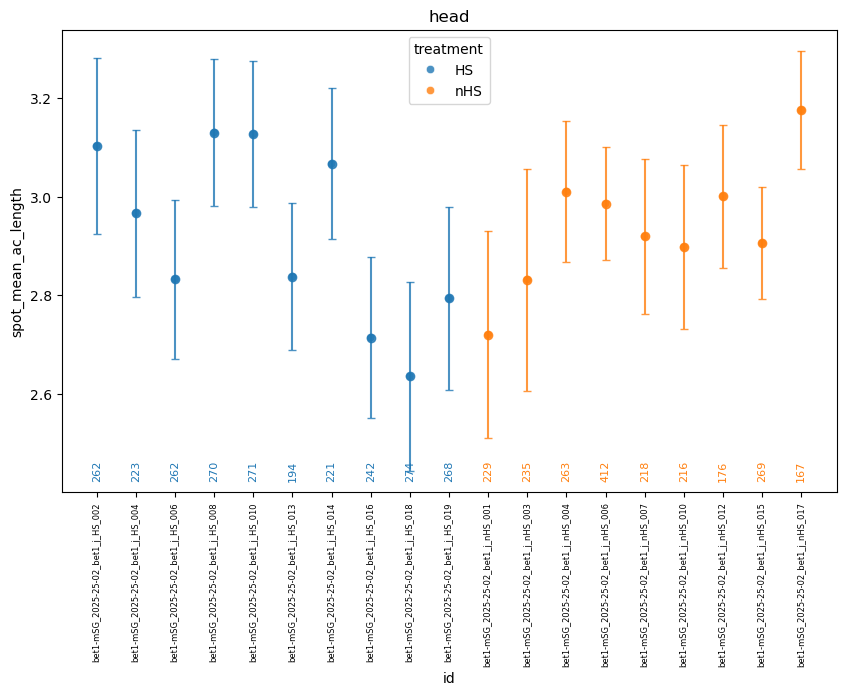

In [426]:
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="head"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='head')

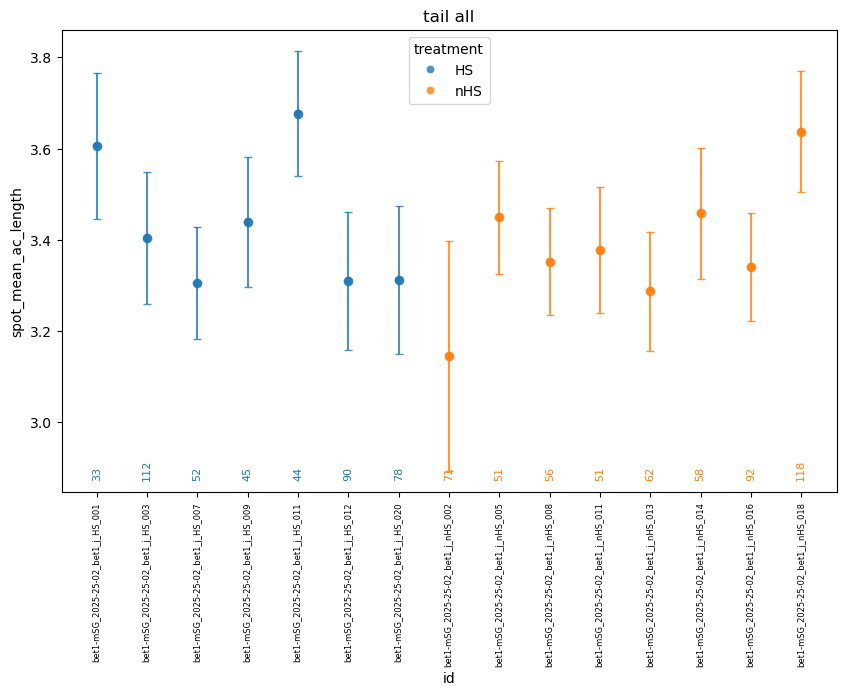

In [427]:
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="tail"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='tail all')

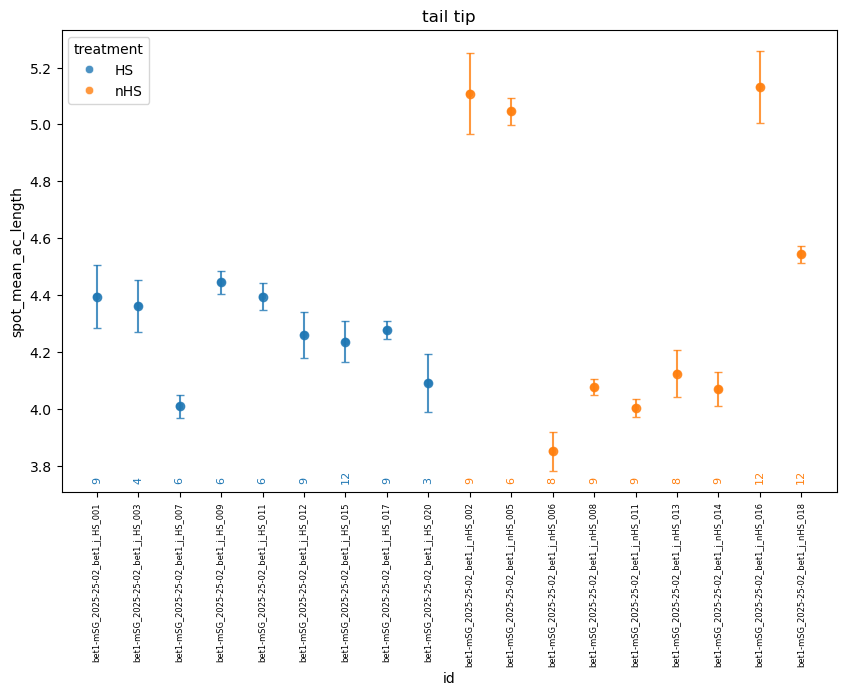

In [428]:
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="tailnuc"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='tail tip')

In [429]:
dist_subset.head()

,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,image,intensity_image,worm_region,intensity_background,mask_background,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,intensity_dist_spots,intensity_dist,zproj_spots,zproj_background,anisotropy,pixelSize,spot_ACF,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,spot_ac_fittedParams,spot_ac_fittedParams_err,bg_ACF,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,bg_ac_fittedParams,bg_ac_fittedParams_err
6,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,54,29,1636,1311,44,1699,1345,16747.0,35.867140,1666.945065,1327.807368,71.498410,0.921633,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[147, 140, 152, 156, 156, 151, 129, 122, 147...","[[[True, True, True, True, True, True, True, T...",15,63,34,206.405087,200.0,35.238121,3456666,1241.725198,348,130,16747,155.262238,15.657079,2388399,15383,0,"[176.707182320442, 195.36, 216.768, 224.225, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[0, 0, 0, 0, 0, 0, 0, 140, 181, 184, 207, 183...","[[168, 163, 164, 171, 163, 178, 178, 157, 184,...",3.0,0.065,"[1.0, 0.6715710579142631, 0.5003639990319111, ...",3.304439,0.258179,0.024930,27.832113,"[0.024570105986196602, 0.9364006811172482, 0.3...","[0.02064871466052587, 0.02708453560733401, 0.0...","[1.0, 0.2526052632544905, 0.1899400138618876, ...",1.498586,0.199983,0.038077,240.675730,"[0.06929506773365267, 0.9241619175782482, 1.39...","[0.013958351624653843, 0.0452652444529069, 0.1..."
7,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,57,32,1913,1375,51,1964,1411,21025.0,41.718906,1937.760999,1392.732794,55.738910,0.949467,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[144, 159, 164, 140, 142, 157, 139, 161, 130...","[[[True, True, True, True, True, True, True, T...",19,51,36,193.815553,190.0,26.581066,4074972,706.553090,327,125,21025,156.216682,12.833086,2165007,13859,0,"[169.875, 185.90131578947367, 196.211009174311...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 171, 1...","[[165, 176, 170, 171, 188, 181, 173, 163, 181,...",3.0,0.065,"[1.0, 0.6083447971263635, 0.5187650157087687, ...",3.305645,0.385501,0.035668,27.853984,"[0.04212023656245886, 0.8978475988439012, 0.30...","[0.02956278284868639, 0.038754477949522616, 0....","[1.0, 0.06700731851017813, 0.03894390000953022...",1.252843,0.082138,0.009658,3488.645342,"[0.006766062343403017, 0.9931097447783807, 2.7...","[0.003362536696730917, 0.01150942104974418, 0...."
11,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,54,29,1636,1311,44,1699,1345,16747.0,35.867140,1666.945065,1327.807368,71.498410,0.921633,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[147, 140, 152, 156, 156, 151, 129, 122, 147...","[[[True, True, True, True, True, True, True, T...",15,63,34,206.405087,200.0,35.238121,3456666,1241.725198,348,130,16747,155.262238,15.657079,2388399,15383,0,"[176.707182320442, 195.36, 216.768, 224.225, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[0, 0, 0, 0, 0, 0, 0, 140, 181, 184, 207, 183...","[[168, 163, 164, 171, 163, 178, 178,

In [430]:
dist_subset.head()

,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,image,intensity_image,worm_region,intensity_background,mask_background,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,intensity_dist_spots,intensity_dist,zproj_spots,zproj_background,anisotropy,pixelSize,spot_ACF,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,spot_ac_fittedParams,spot_ac_fittedParams_err,bg_ACF,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,bg_ac_fittedParams,bg_ac_fittedParams_err
6,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,54,29,1636,1311,44,1699,1345,16747.0,35.867140,1666.945065,1327.807368,71.498410,0.921633,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[147, 140, 152, 156, 156, 151, 129, 122, 147...","[[[True, True, True, True, True, True, True, T...",15,63,34,206.405087,200.0,35.238121,3456666,1241.725198,348,130,16747,155.262238,15.657079,2388399,15383,0,"[176.707182320442, 195.36, 216.768, 224.225, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[0, 0, 0, 0, 0, 0, 0, 140, 181, 184, 207, 183...","[[168, 163, 164, 171, 163, 178, 178, 157, 184,...",3.0,0.065,"[1.0, 0.6715710579142631, 0.5003639990319111, ...",3.304439,0.258179,0.024930,27.832113,"[0.024570105986196602, 0.9364006811172482, 0.3...","[0.02064871466052587, 0.02708453560733401, 0.0...","[1.0, 0.2526052632544905, 0.1899400138618876, ...",1.498586,0.199983,0.038077,240.675730,"[0.06929506773365267, 0.9241619175782482, 1.39...","[0.013958351624653843, 0.0452652444529069, 0.1..."
7,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,57,32,1913,1375,51,1964,1411,21025.0,41.718906,1937.760999,1392.732794,55.738910,0.949467,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[144, 159, 164, 140, 142, 157, 139, 161, 130...","[[[True, True, True, True, True, True, True, T...",19,51,36,193.815553,190.0,26.581066,4074972,706.553090,327,125,21025,156.216682,12.833086,2165007,13859,0,"[169.875, 185.90131578947367, 196.211009174311...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 171, 1...","[[165, 176, 170, 171, 188, 181, 173, 163, 181,...",3.0,0.065,"[1.0, 0.6083447971263635, 0.5187650157087687, ...",3.305645,0.385501,0.035668,27.853984,"[0.04212023656245886, 0.8978475988439012, 0.30...","[0.02956278284868639, 0.038754477949522616, 0....","[1.0, 0.06700731851017813, 0.03894390000953022...",1.252843,0.082138,0.009658,3488.645342,"[0.006766062343403017, 0.9931097447783807, 2.7...","[0.003362536696730917, 0.01150942104974418, 0...."
11,bet1_j_HS_001,2025-25-02,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-25-02_bet1_j_HS_001,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,/Volumes/external.data/MeisterLab/Kalyan/TF_st...,tailnuc;body_other;tail,54,29,1636,1311,44,1699,1345,16747.0,35.867140,1666.945065,1327.807368,71.498410,0.921633,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",body_other,"[[[147, 140, 152, 156, 156, 151, 129, 122, 147...","[[[True, True, True, True, True, True, True, T...",15,63,34,206.405087,200.0,35.238121,3456666,1241.725198,348,130,16747,155.262238,15.657079,2388399,15383,0,"[176.707182320442, 195.36, 216.768, 224.225, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[0, 0, 0, 0, 0, 0, 0, 140, 181, 184, 207, 183...","[[168, 163, 164, 171, 163, 178, 178,

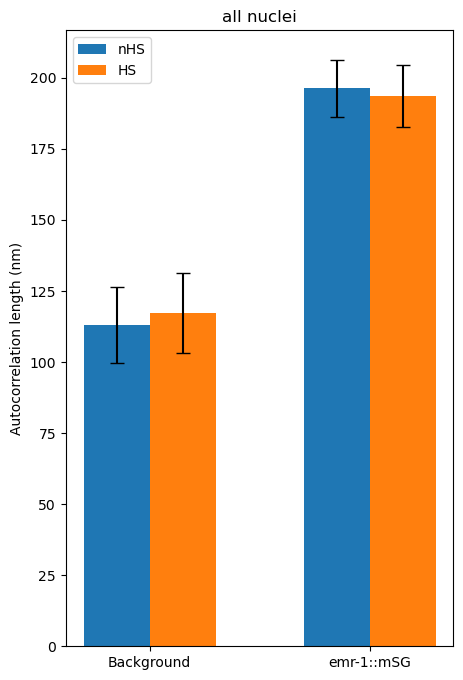

In [431]:
dist_subset = dist[(dist['worm_region'] != "tailnuc")]
plot_ac_length_barplot(dist_subset,title='all nuclei')

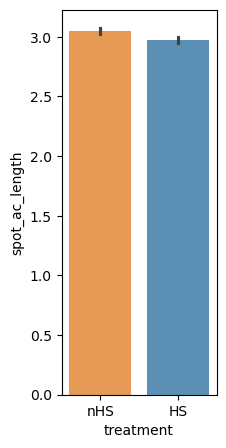

In [432]:
plt.figure(figsize=(2, 5))
#sns.barplot(data=dist[dist.worm_region=="tailnuc"], x='treatment',y='spot_ac_length',
#            hue='treatment', palette='tab10', alpha=0.8, order=['nHS', 'HS'])

ax =sns.barplot(data=dist, x='treatment',y='spot_ac_length',
            hue='treatment', palette='tab10', alpha=0.8, order=['nHS', 'HS'])
#ax.set_ylim(0,4.1)

Text(0.5, 0, 'Distance (nm)')

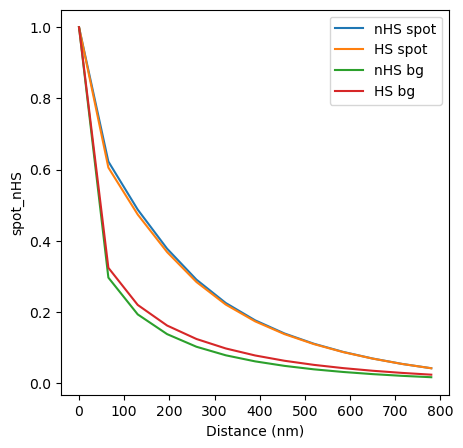

In [433]:
spotCurves = get_acf_curves(dist,image_type="spot")
bgCurves = get_acf_curves(dist,image_type="bg")

curves = pd.DataFrame({'pixels': range(0,len(spotCurves.ACF[0])),
                'spot_'+spotCurves.treatment[0]: spotCurves.ACF[0],
                'spot_'+spotCurves.treatment[1]: spotCurves.ACF[1],
                'bg_'+bgCurves.treatment[0]: bgCurves.ACF[0],
                'bg_'+bgCurves.treatment[1]: bgCurves.ACF[1]})

curves['distance'] = curves['pixels']*dist.pixelSize[0]*1000


plt.figure(figsize=(5, 5))
sns.lineplot(data=curves, x='distance', y='spot_nHS', label='nHS spot')
sns.lineplot(data=curves, x='distance', y='spot_HS', label='HS spot')
sns.lineplot(data=curves, x='distance', y='bg_nHS', label='nHS bg')
sns.lineplot(data=curves, x='distance', y='bg_HS', label='HS bg')
plt.xlabel('Distance (nm)')

In [434]:

def histogram_parameter_value(parameter_values, parameter_name):
    plt.hist(parameter_values, bins=100)
    mean_p = np.mean(parameter_values)
    median_p = np.median(parameter_values)
    plt.axvline(mean_p, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_p:.3f}')
    plt.axvline(median_p, color='blue', linestyle=':', linewidth=1, label=f'Median: {median_p:.3f}')
    plt.title('parameter: '+parameter_name)
    plt.legend()
    plt.title('paramter: '+parameter_name)
    plt.show()



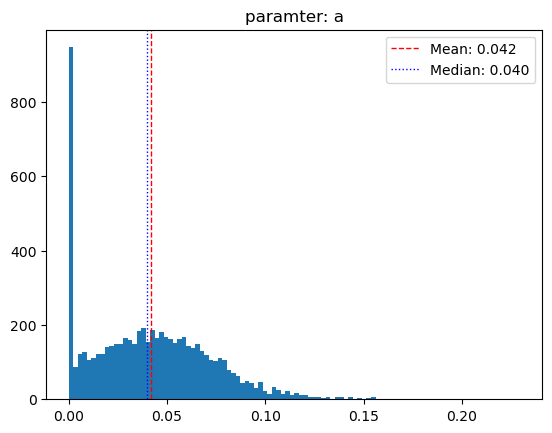

In [435]:
a=[p[0] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(a, 'a')

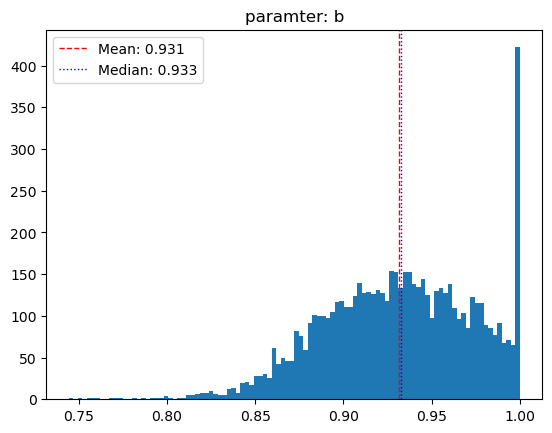

In [436]:
b=[p[1] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(b, 'b')

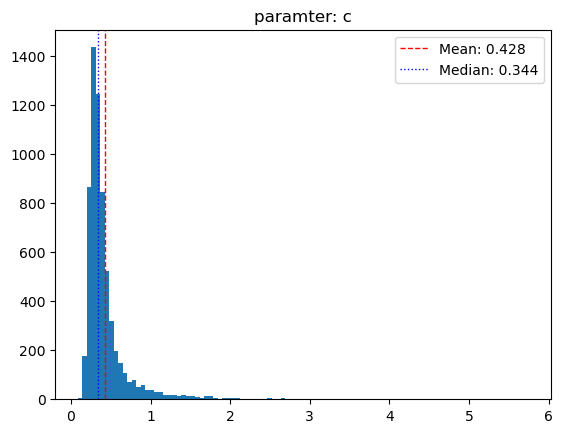

In [437]:
c=[p[2] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(c, 'c')